In [1]:
# from https://www.kaggle.com/code/mrankitgupta/spotify-data-analysis-using-python
# and from # https://github.com/enjuichang/PracticalDataScience-ENCA
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
#import json
import pandas as pd
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
# import for recommendation
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# setting up the credentials
client_id = "2ca89022ac6348b99eb6e5cb99583158"
client_secret = "4dd5feb53234451f9952db292972a656"
auth_url = 'https://accounts.spotify.com/api/token'

os.environ['SPOTIPY_CLIENT_ID'] = client_id
os.environ['SPOTIPY_CLIENT_SECRET'] = client_secret
os.environ['SPOTIPY_REDIRECT_URI'] = 'http://localhost:1410/'

data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
    'scope': 'user-top-read'
}

# get access token
auth_response = requests.post(auth_url, data=data)
access_token = auth_response.json().get('access_token')

# access api
base_url = 'https://api.spotify.com/v1/'

headers = {
    'Authorization': 'Bearer {}'.format(access_token)
}

In [2]:
# Request top tracks data and create top tracks dataframe

# set up authorisation for user data
scope = "user-top-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

#https://www.linkedin.com/pulse/analyse-your-spotify-data-python-spotipy-shai-nisan-ph-d-/
user_top_tracks = sp.current_user_top_tracks(limit=50)
user_top_tracks2 = sp.current_user_top_tracks(limit=50, offset = 50)

# create lists for future iteration
top_track_ids = []
top_track_titles = []

for i in user_top_tracks['items']:
    top_track_ids.append(i['id'])
    top_track_titles.append(i['name'])
#for i in user_top_tracks2['items']:
#    top_track_ids.append(i['id'])
#    top_track_titles.append(i['name'])

#create a dataframe
top_features = sp.audio_features(top_track_ids)
top_features_df = pd.DataFrame(data=top_features, columns=top_features[0].keys())
top_features_df.drop(columns=["type", "id","uri","track_href", "analysis_url", "time_signature"], inplace=True)

top_features_df.head()



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.399,0.7610,9,-6.318,1,0.0334,0.000105,0.0456,0.0757,0.2430,140.084,304907
1,0.252,0.1880,1,-11.648,1,0.0456,0.329000,0.1210,0.1000,0.0302,86.997,113773
2,0.404,0.4070,5,-11.843,1,0.0299,0.492000,0.0338,0.3910,0.0848,106.547,189293
3,0.430,0.2560,2,-15.737,1,0.0607,0.161000,0.8520,0.1470,0.2080,96.704,330905
4,0.213,0.0695,11,-14.832,1,0.0409,0.018500,0.9580,0.1240,0.0382,112.192,106213


In [3]:
# Func to store daily mix info, returns dataframe with 'features'
# https://medium.com/codex/decoding-spotify-daily-mix-73f4783037b4

scope = "user-read-recently-played"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

def fetch_daily_mix(id):

    result = sp.playlist(id)

    track_ids = []

    for i in result['tracks']['items']:
        track = i['track']
        track_ids.append(track['id'])

    features = sp.audio_features(track_ids)
    df = pd.DataFrame(data=features, columns=features[0].keys())
    df.drop(columns=["type", "id","uri","track_href", "analysis_url", "time_signature"], inplace=True)

    return df

In [4]:
# Manually input daily mix playlists, as the API doesn't support a call
# Then combine data
# Daily mixes accessed on 9/4/24

#indie Mix
#https://open.spotify.com/playlist/37i9dQZF1EQqkOPvHGajmW?si=fcdcd0544f99465d
indie_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EQqkOPvHGajmW?si=fcdcd0544f99465d")

#dance/electronic mix
#https://open.spotify.com/playlist/37i9dQZF1EQp9BVPsNVof1?si=7137873e4b1547b9
dance_electronic_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EQp9BVPsNVof1?si=7137873e4b1547b9")

#chill mix
#https://open.spotify.com/playlist/37i9dQZF1EVHGWrwldPRtj?si=0348a4a3a2974cf3
chill_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EVHGWrwldPRtj?si=0348a4a3a2974cf3")

#upbeat mix
#https://open.spotify.com/playlist/37i9dQZF1EVJHK7Q1TBABQ?si=adf2057ec8184d87
upbeat_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EVJHK7Q1TBABQ?si=adf2057ec8184d87")

#pop mix
#https://open.spotify.com/playlist/37i9dQZF1EQncLwOalG3K7?si=b1bb9edee4e14a3a
pop_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EQncLwOalG3K7?si=b1bb9edee4e14a3a")

#folk & acoustic mix
#https://open.spotify.com/playlist/37i9dQZF1EQp62d3Dl7ECY?si=072b53072c9d4a8a
folk_acoustic_mix = fetch_daily_mix("https://open.spotify.com/playlist/37i9dQZF1EQp62d3Dl7ECY?si=072b53072c9d4a8a")

# give the source name for each dataframe
indie_mix['source'] = 'Indie Mix'
dance_electronic_mix['source'] = 'Dance/Elec Mix'
chill_mix['source'] = 'Chill Mix'
upbeat_mix['source'] = 'Upbeat Mix'
pop_mix['source'] = 'Pop Mix'
folk_acoustic_mix['source'] = 'Folk/Acoust Mix'
top_features_df['source'] = 'User Top Tracks'

# merge the dataframes together
spotify_df = pd.concat([top_features_df, indie_mix, dance_electronic_mix, chill_mix, upbeat_mix, pop_mix, folk_acoustic_mix])
# set the sns style for the visualization
sns.set_context('poster')
sns.set_style('dark')


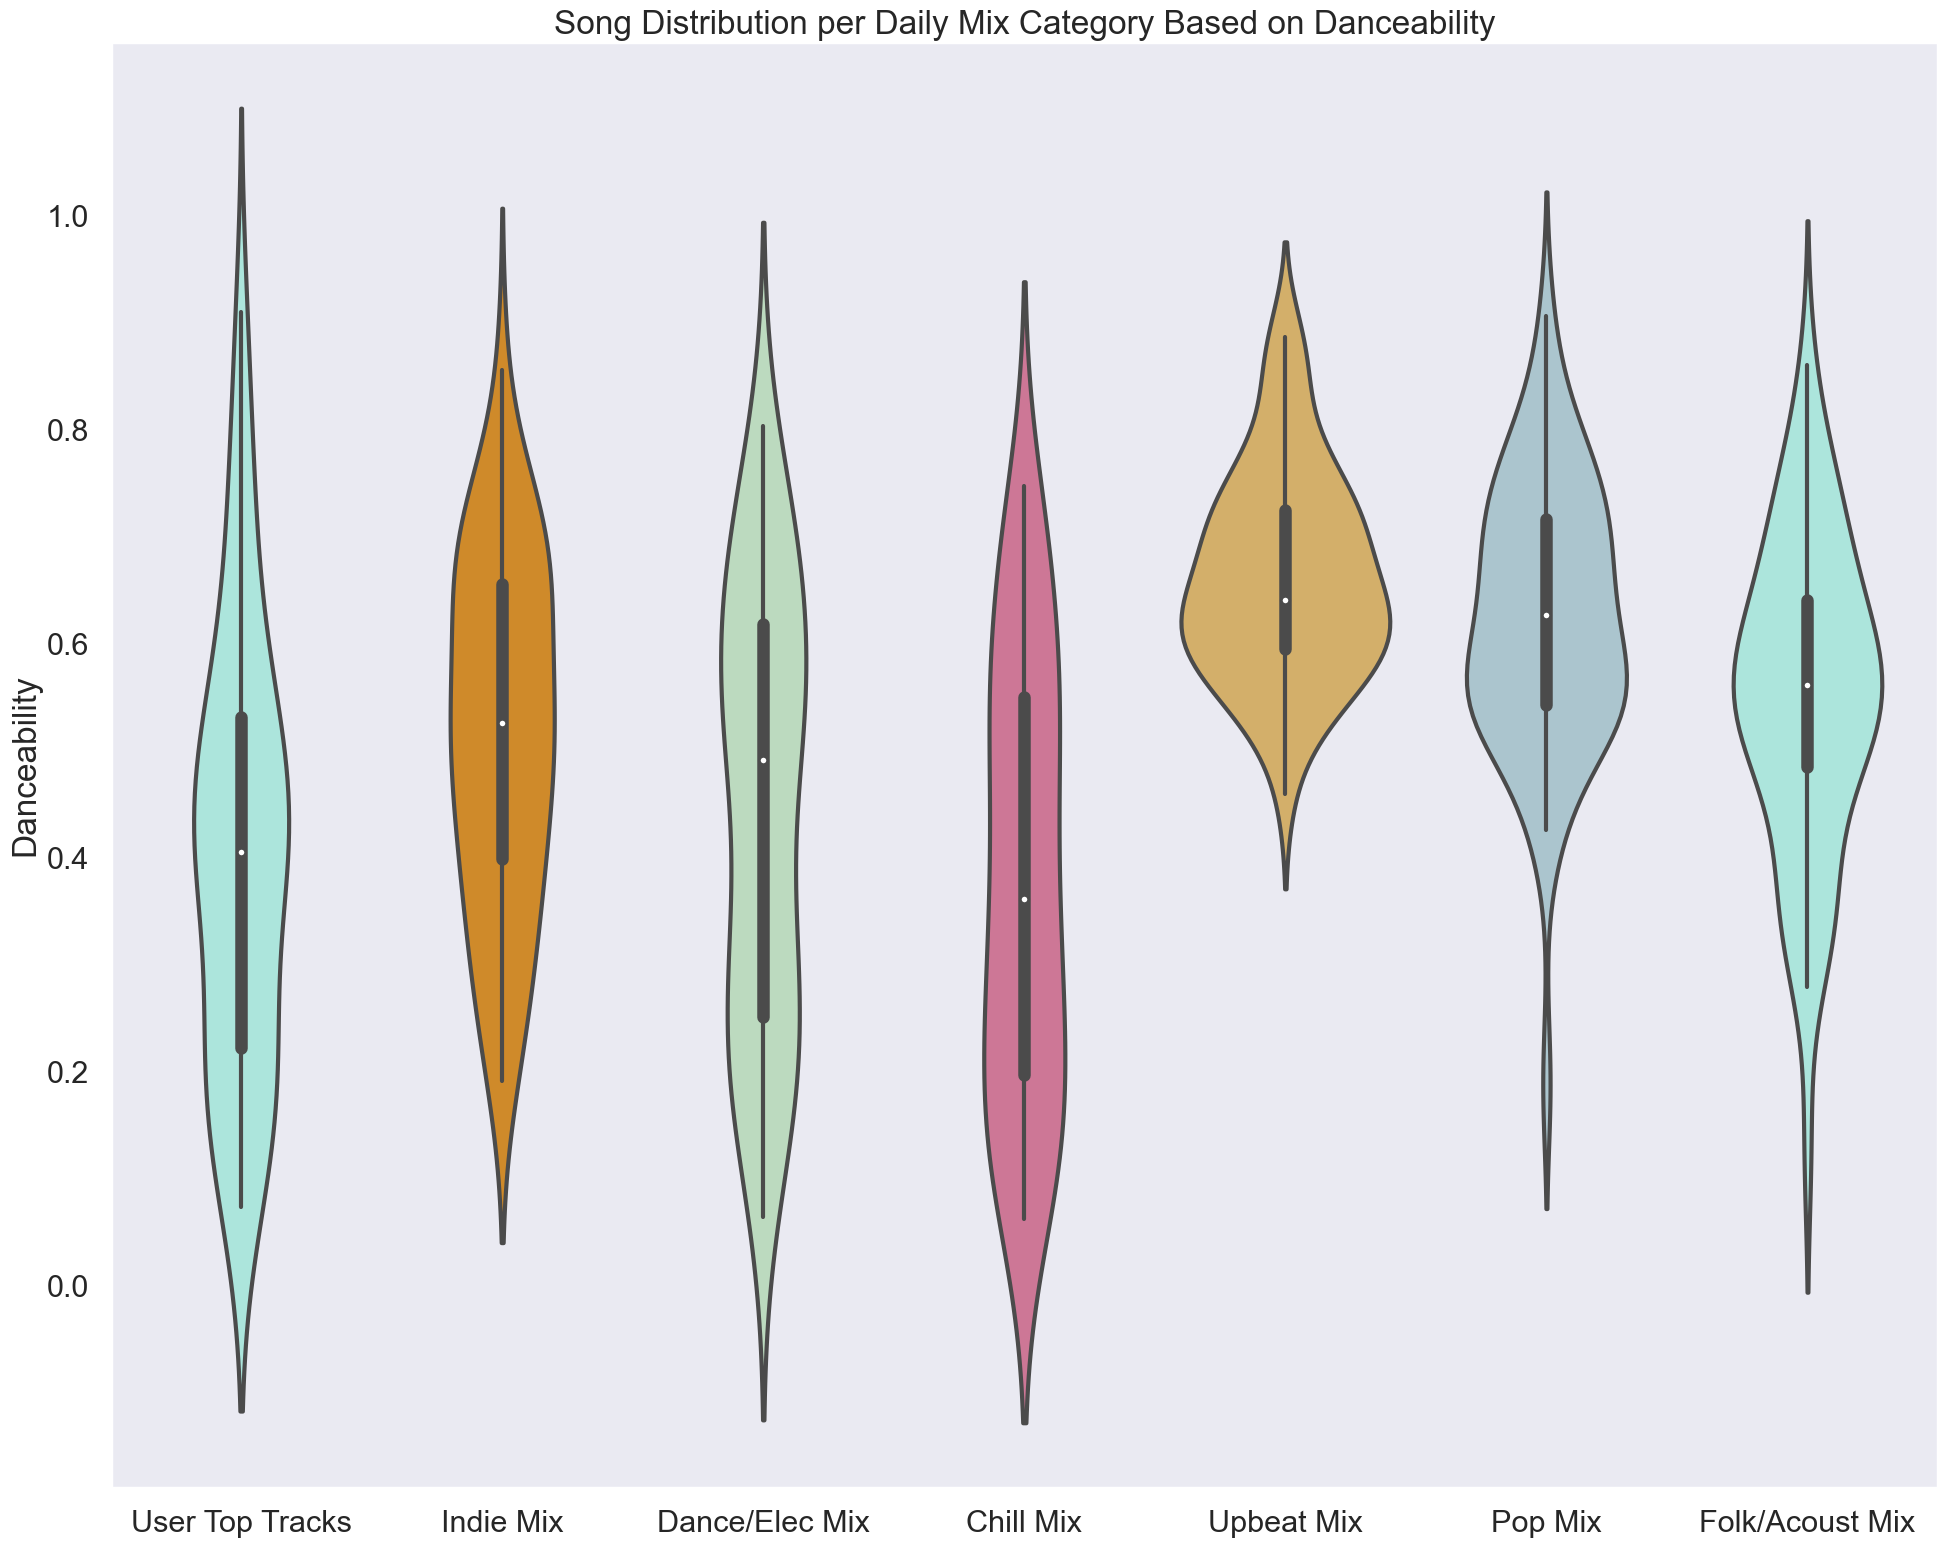

Danceability
Min: 0.0631
Max: 0.91


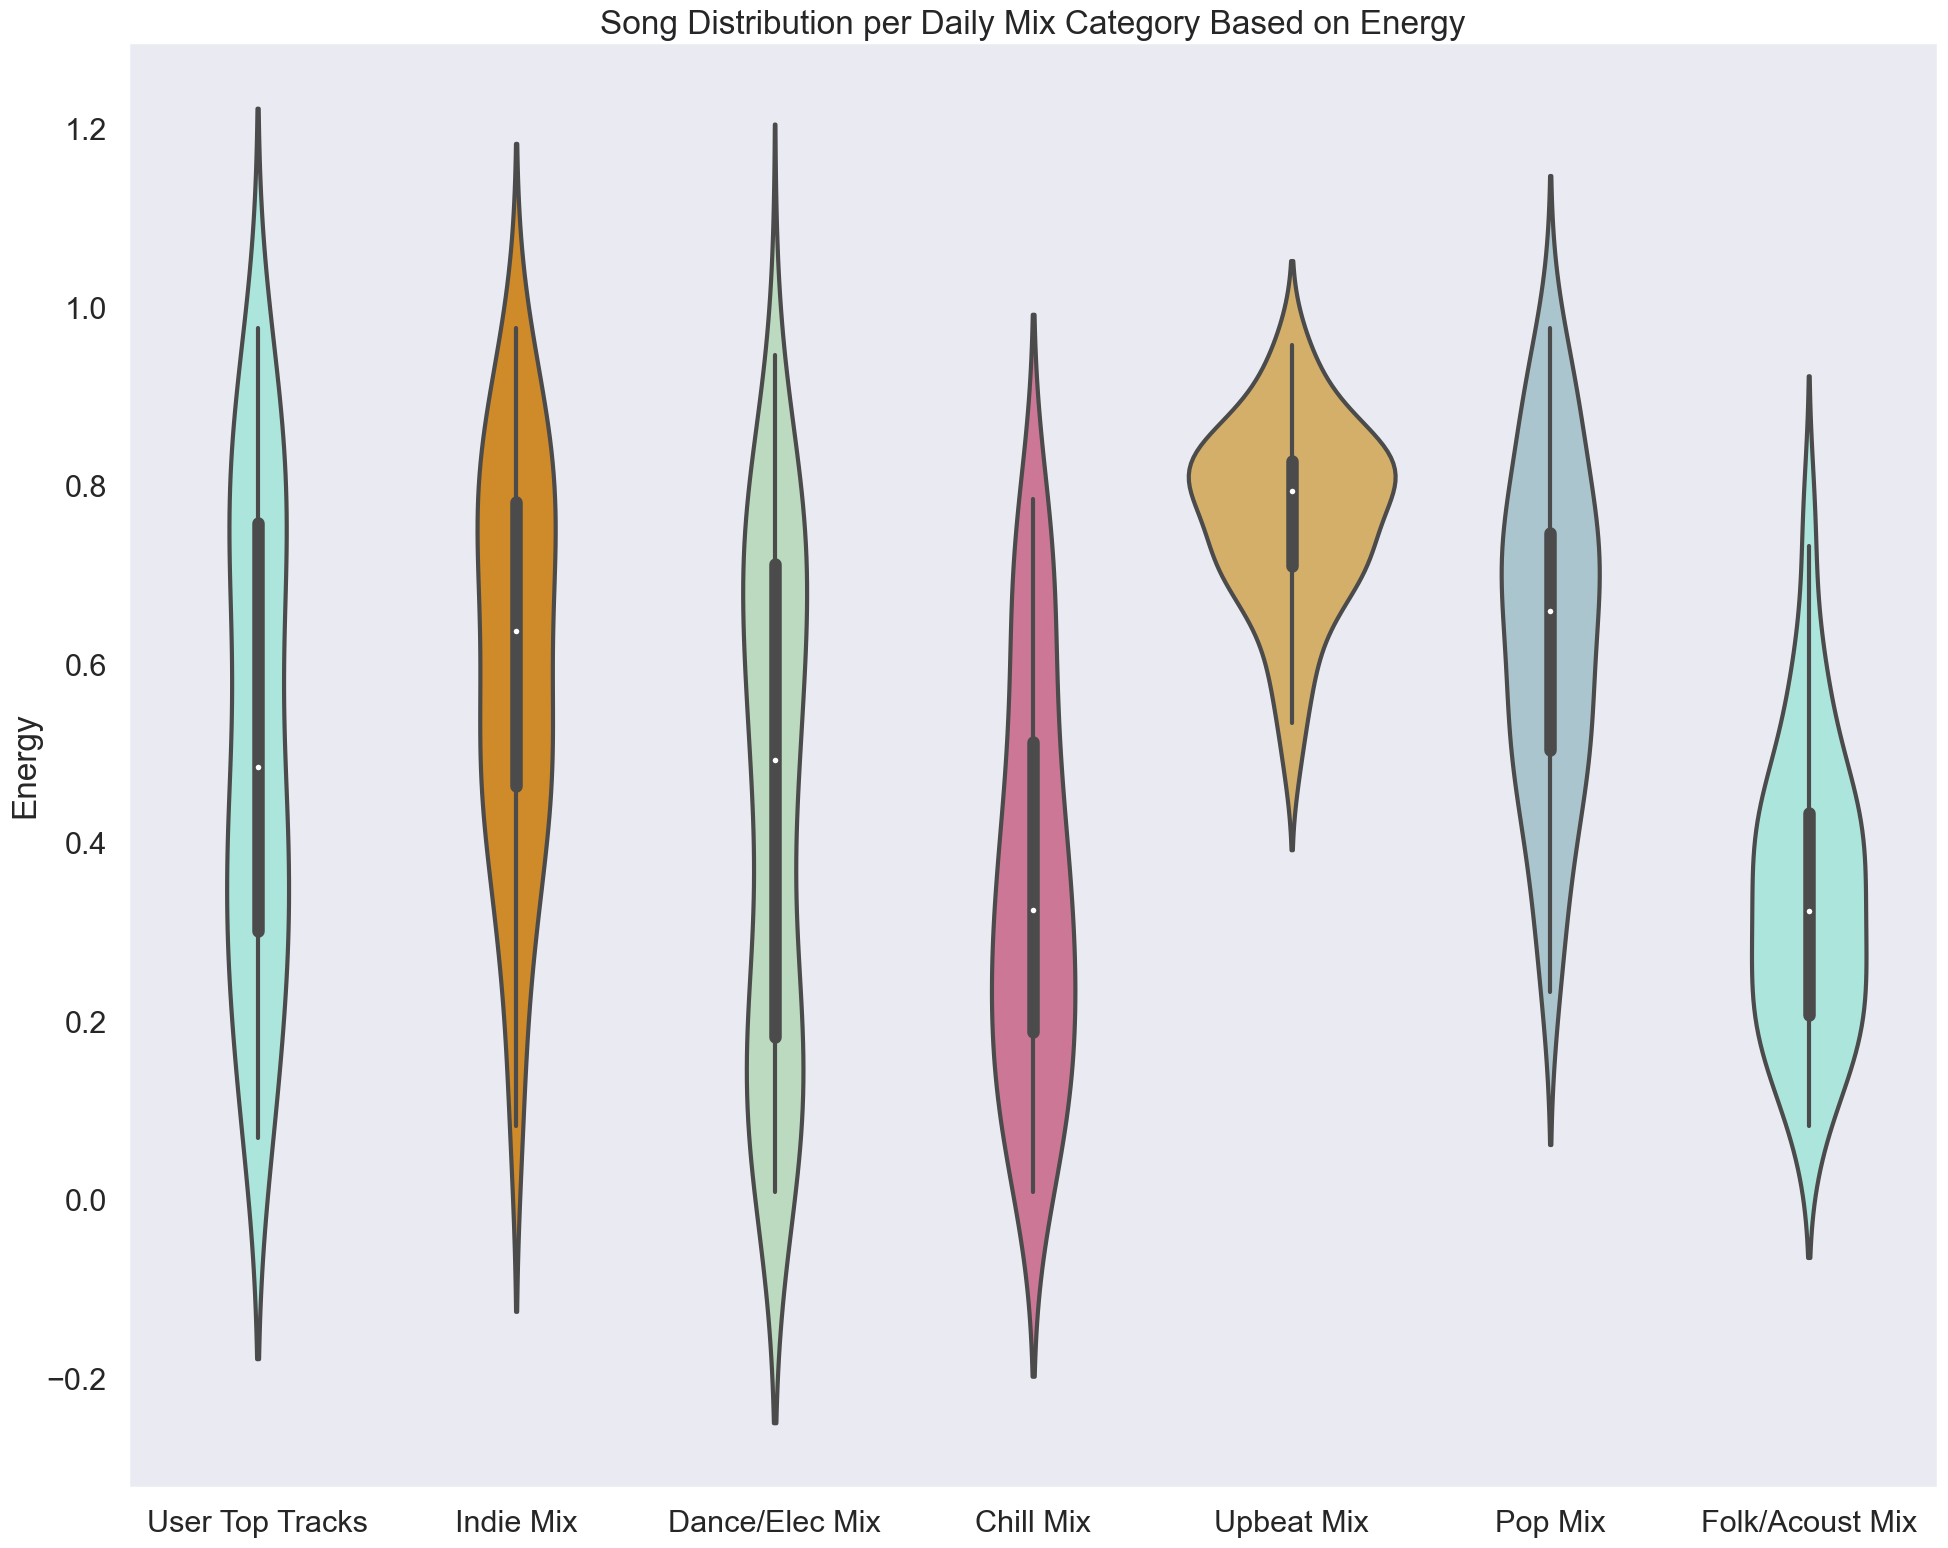

Energy
Min: 0.00995
Max: 0.977


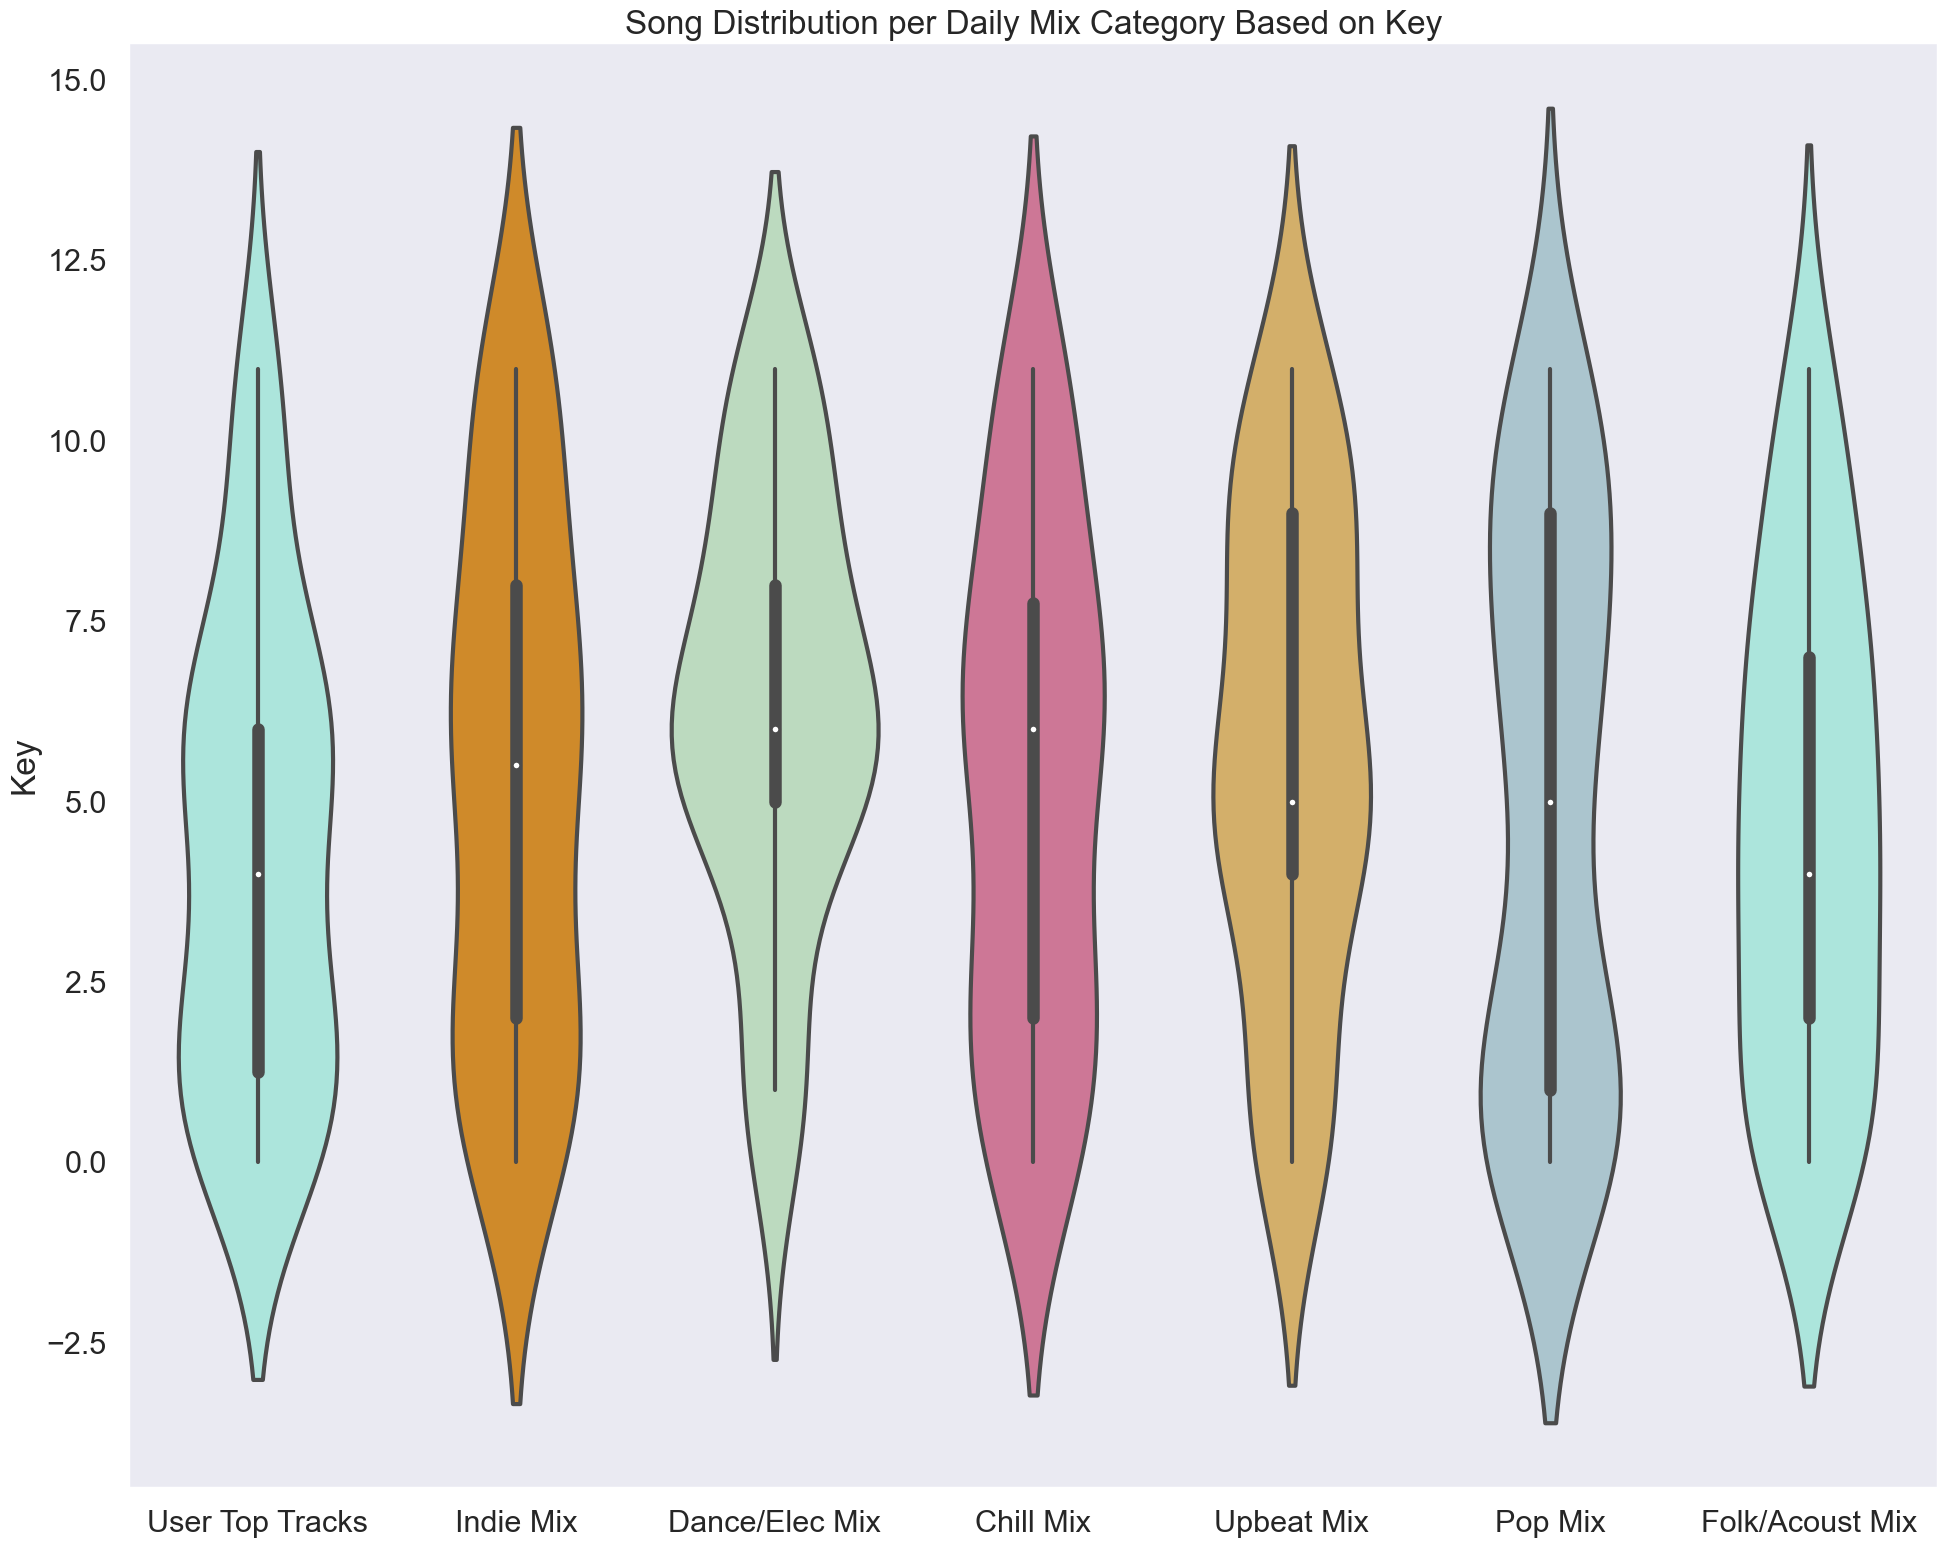

Key
Min: 0
Max: 11


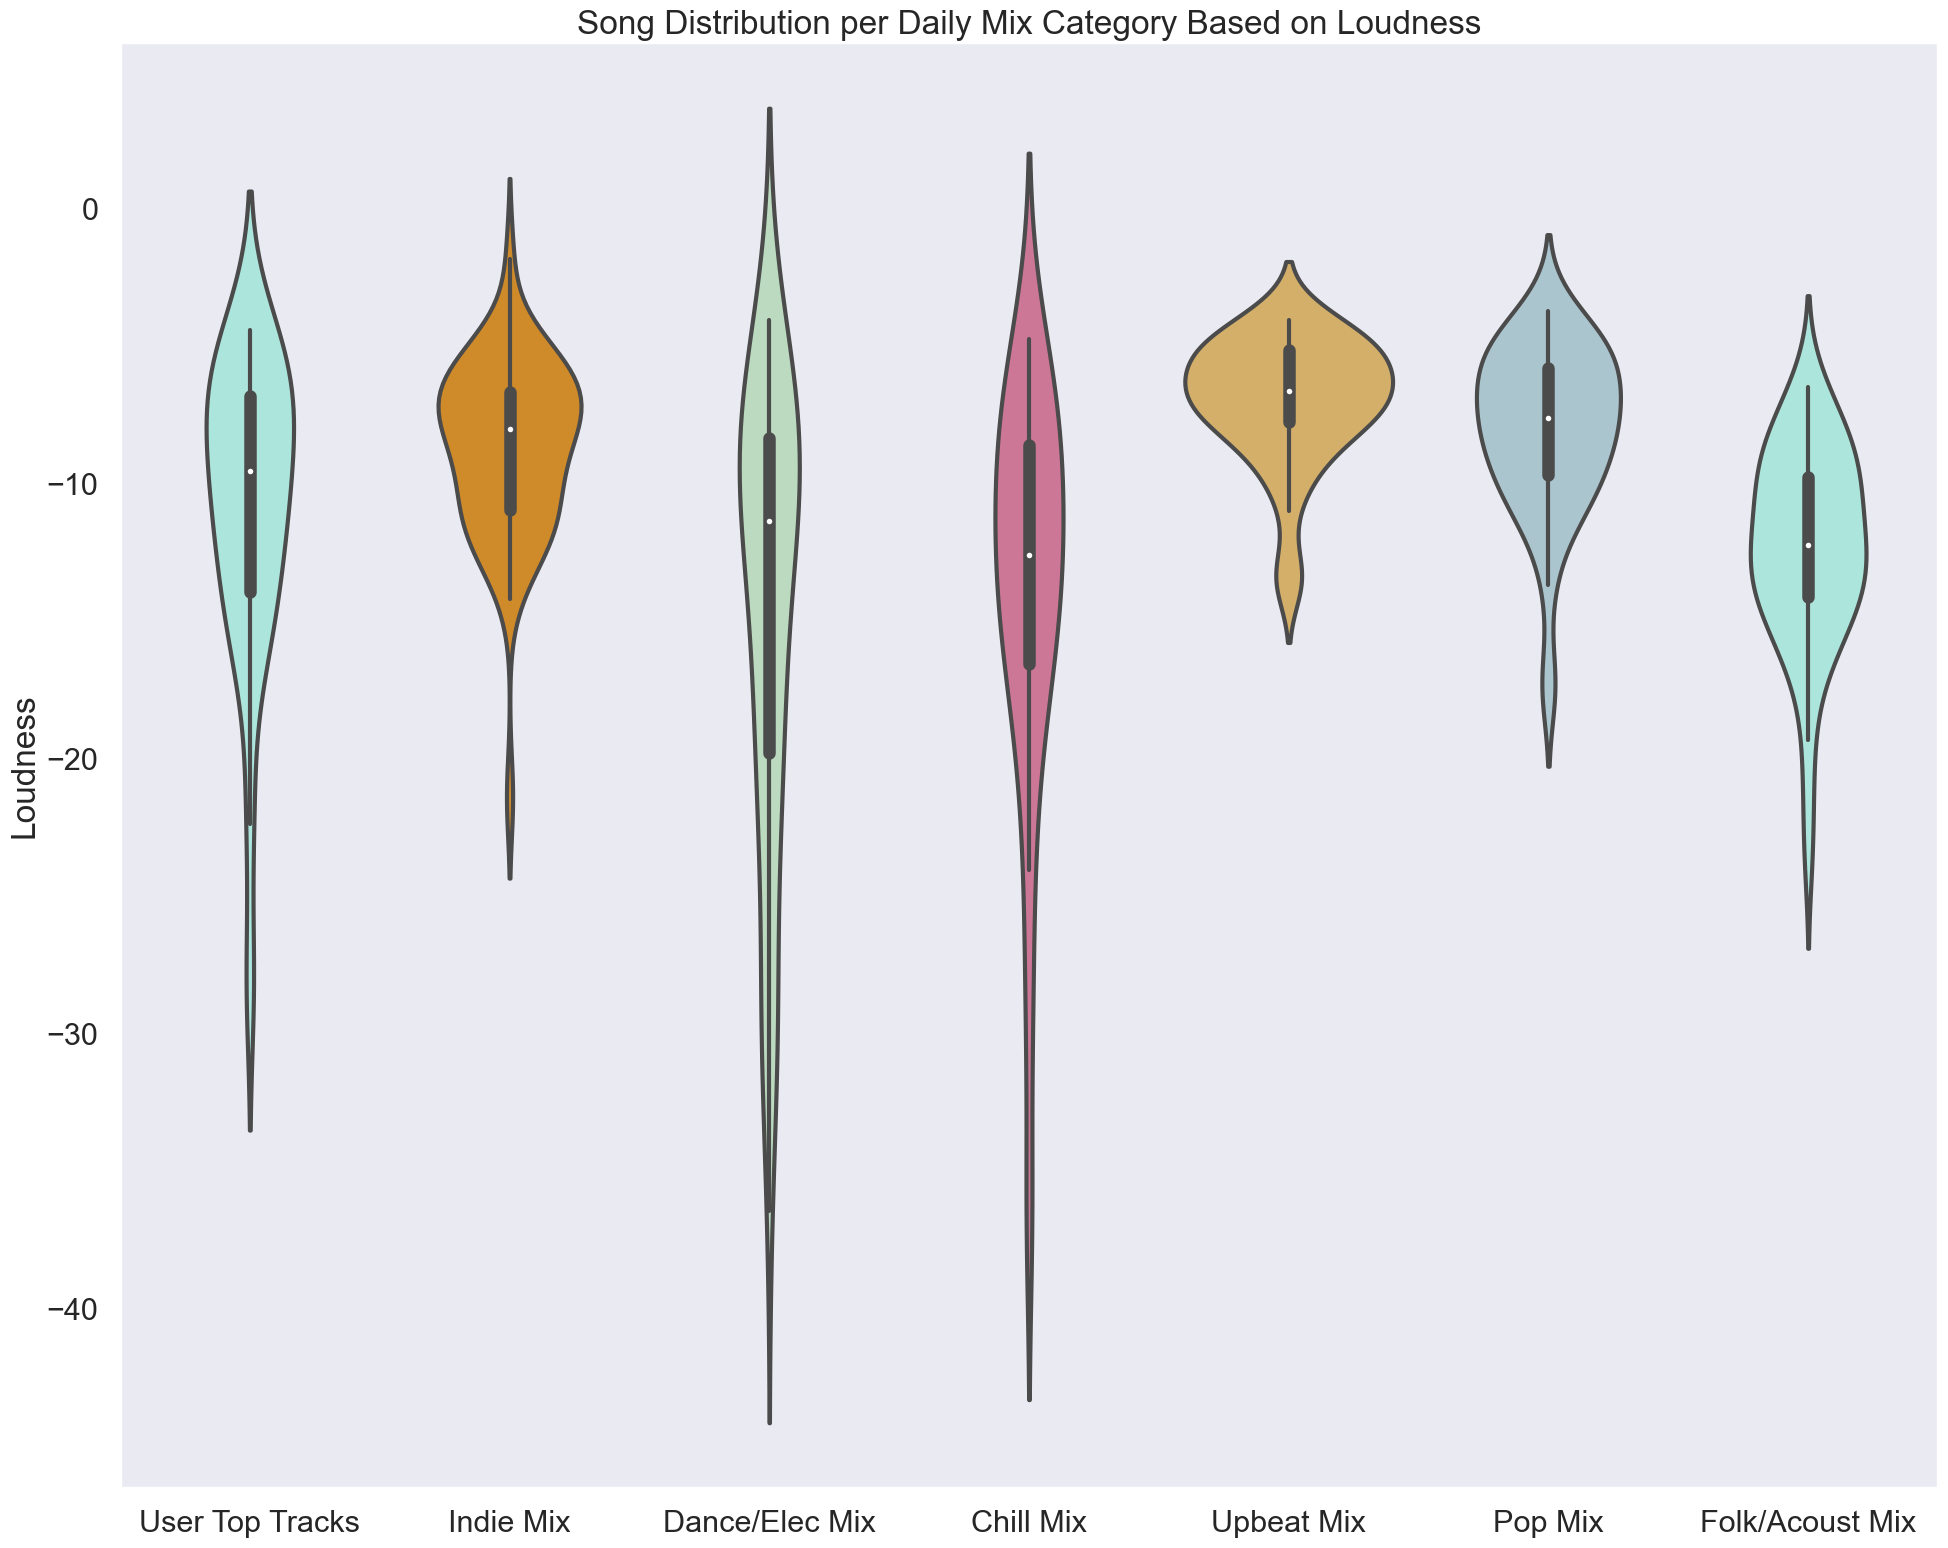

Loudness
Min: -36.528
Max: -1.827


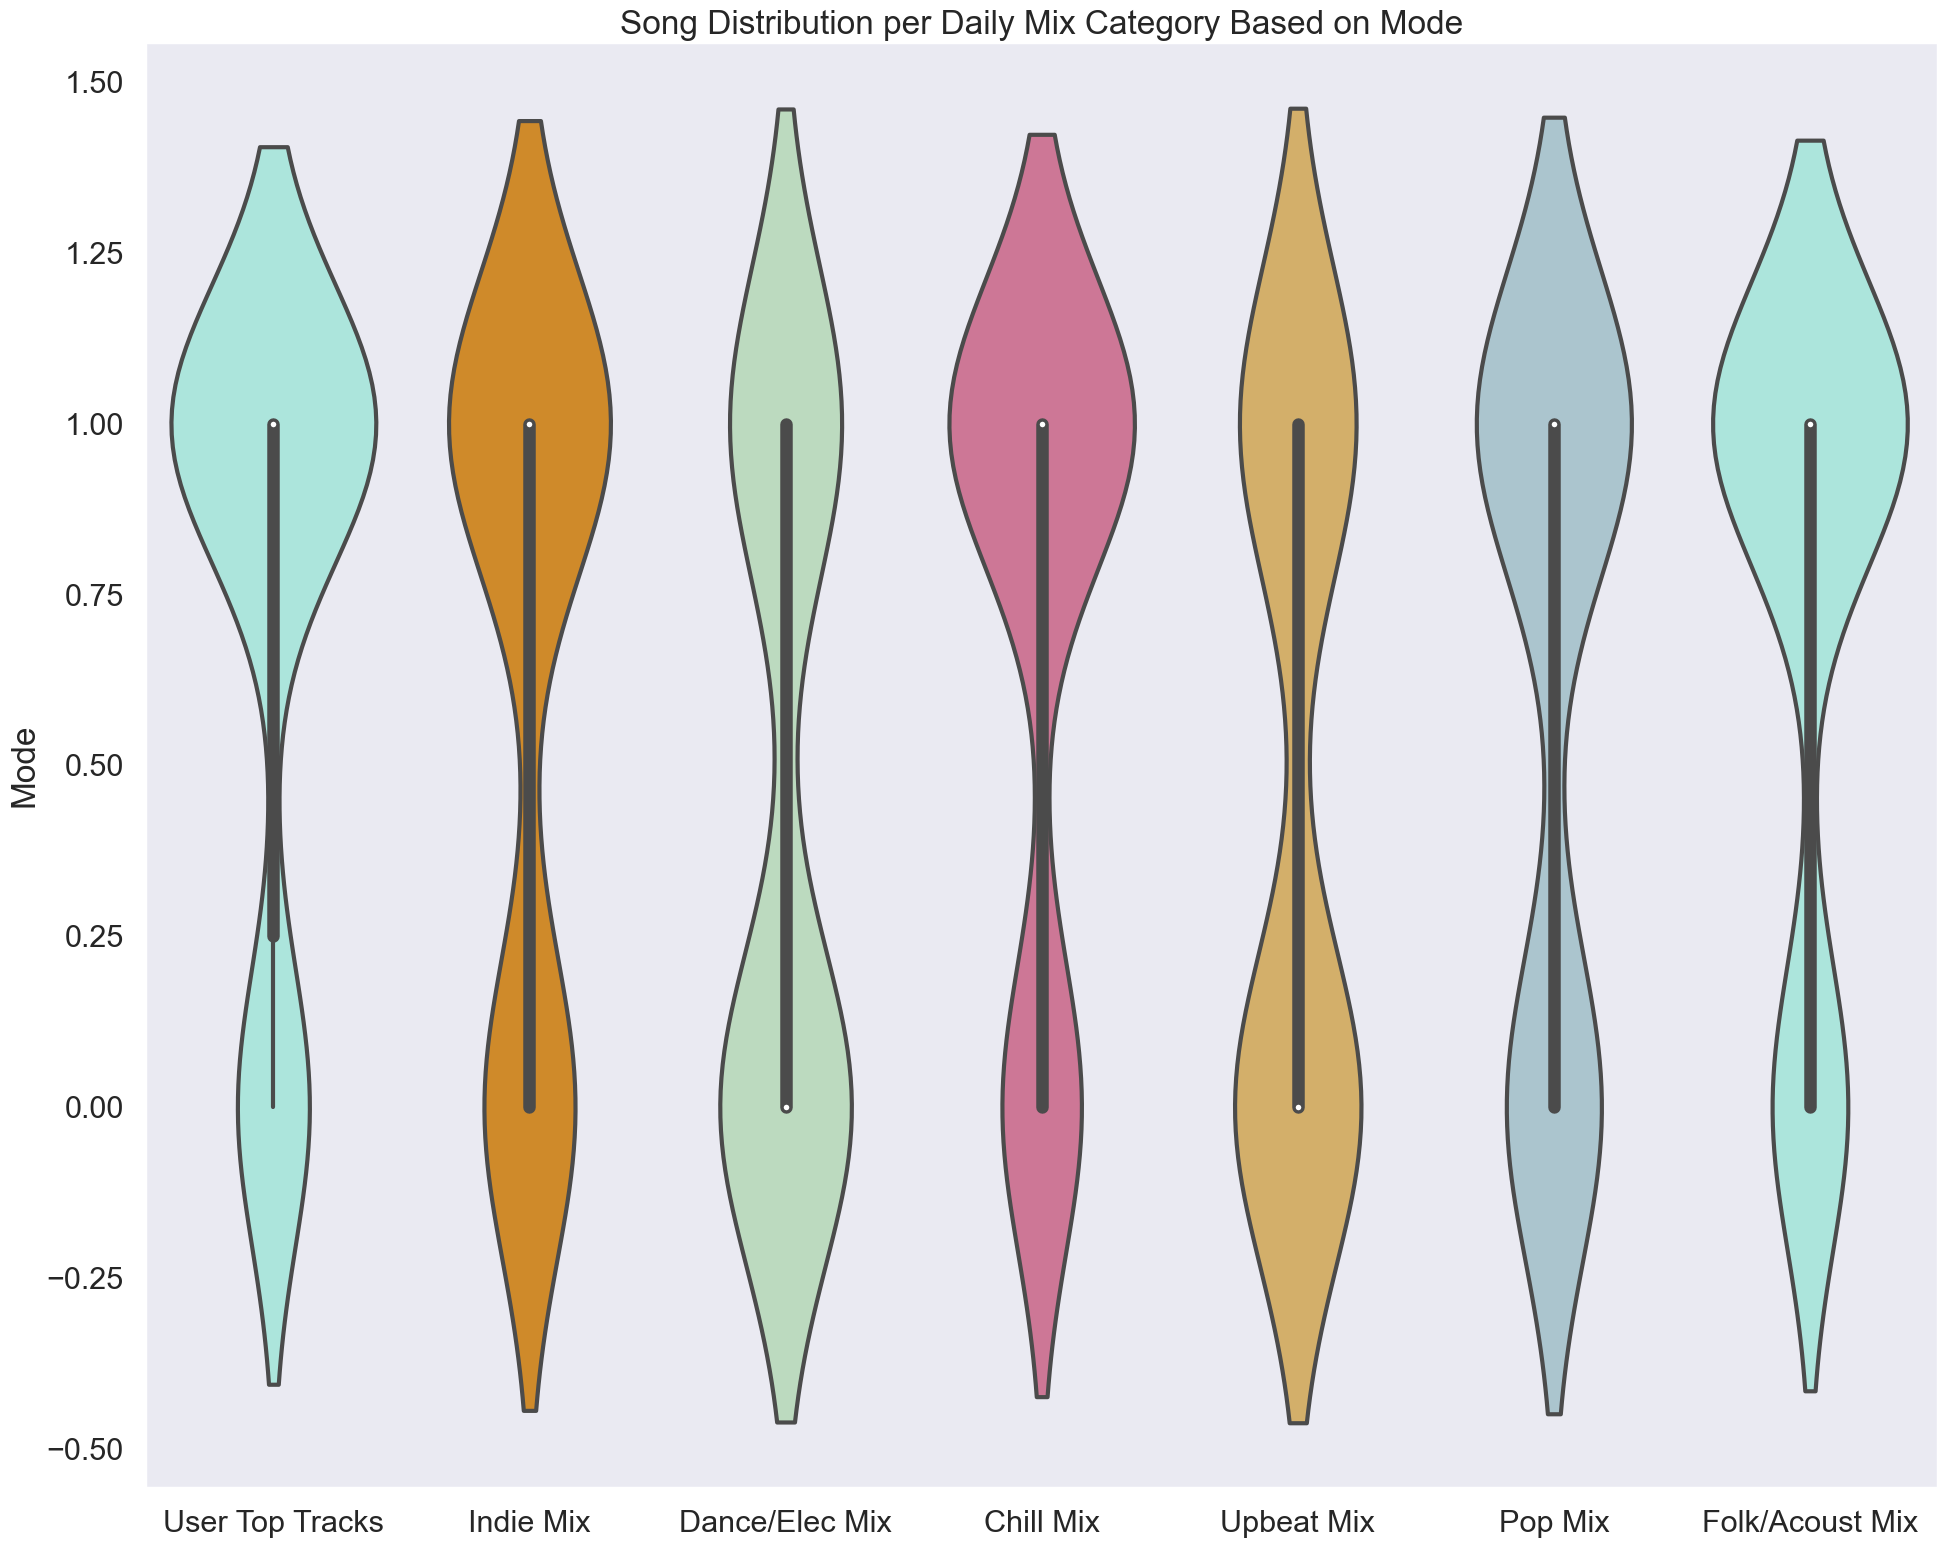

Mode
Min: 0
Max: 1


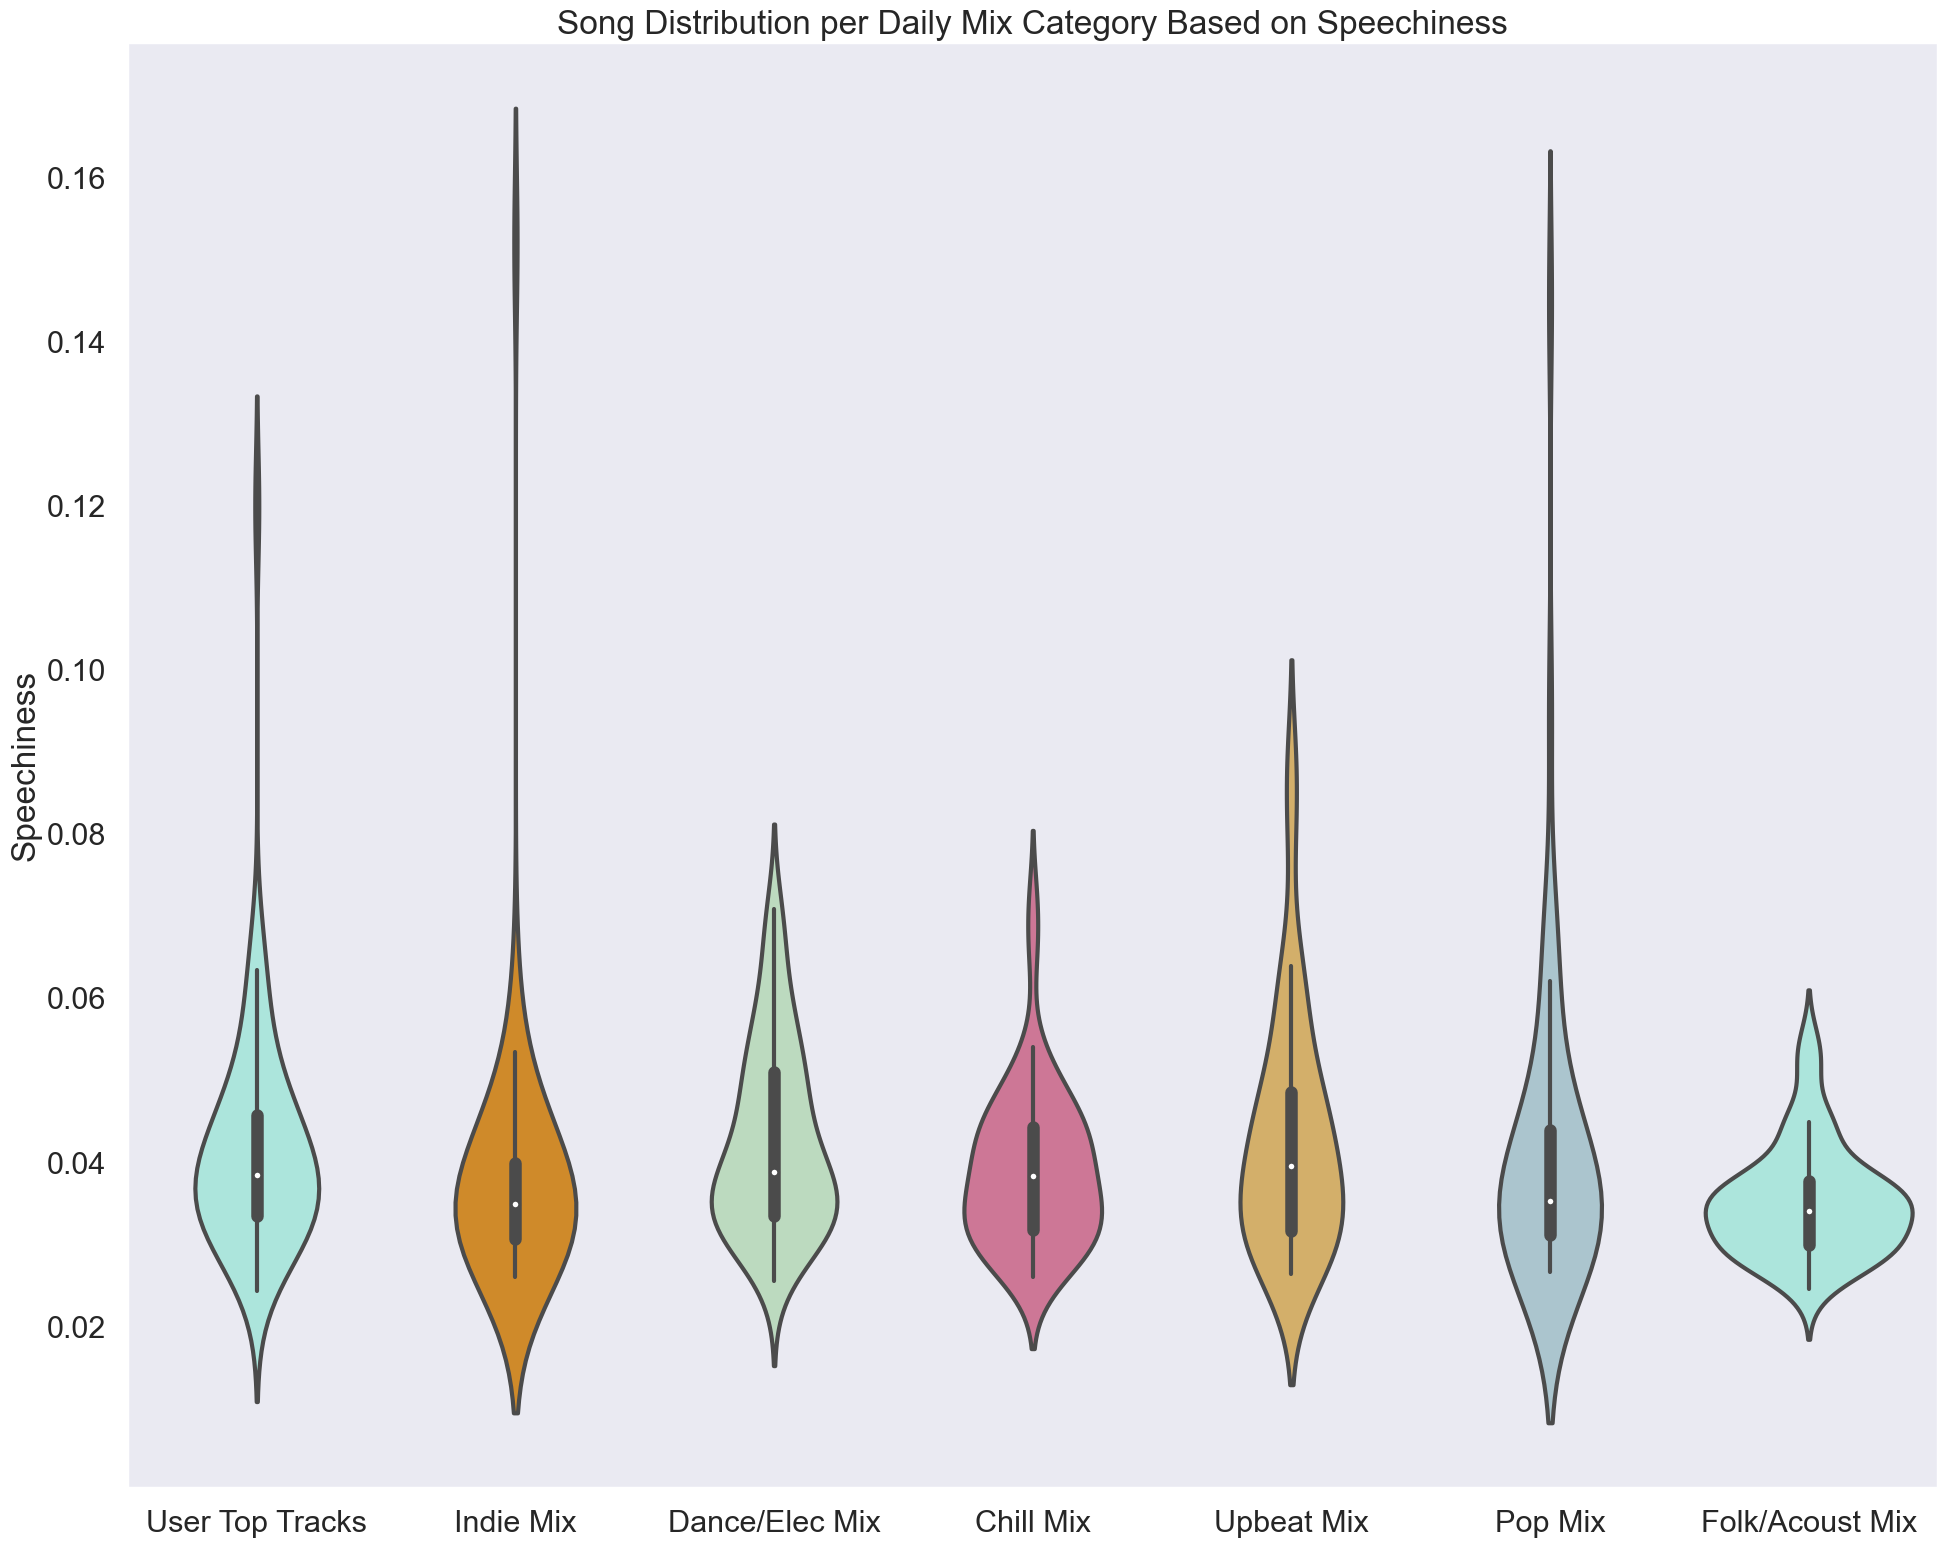

Speechiness
Min: 0.0243
Max: 0.152


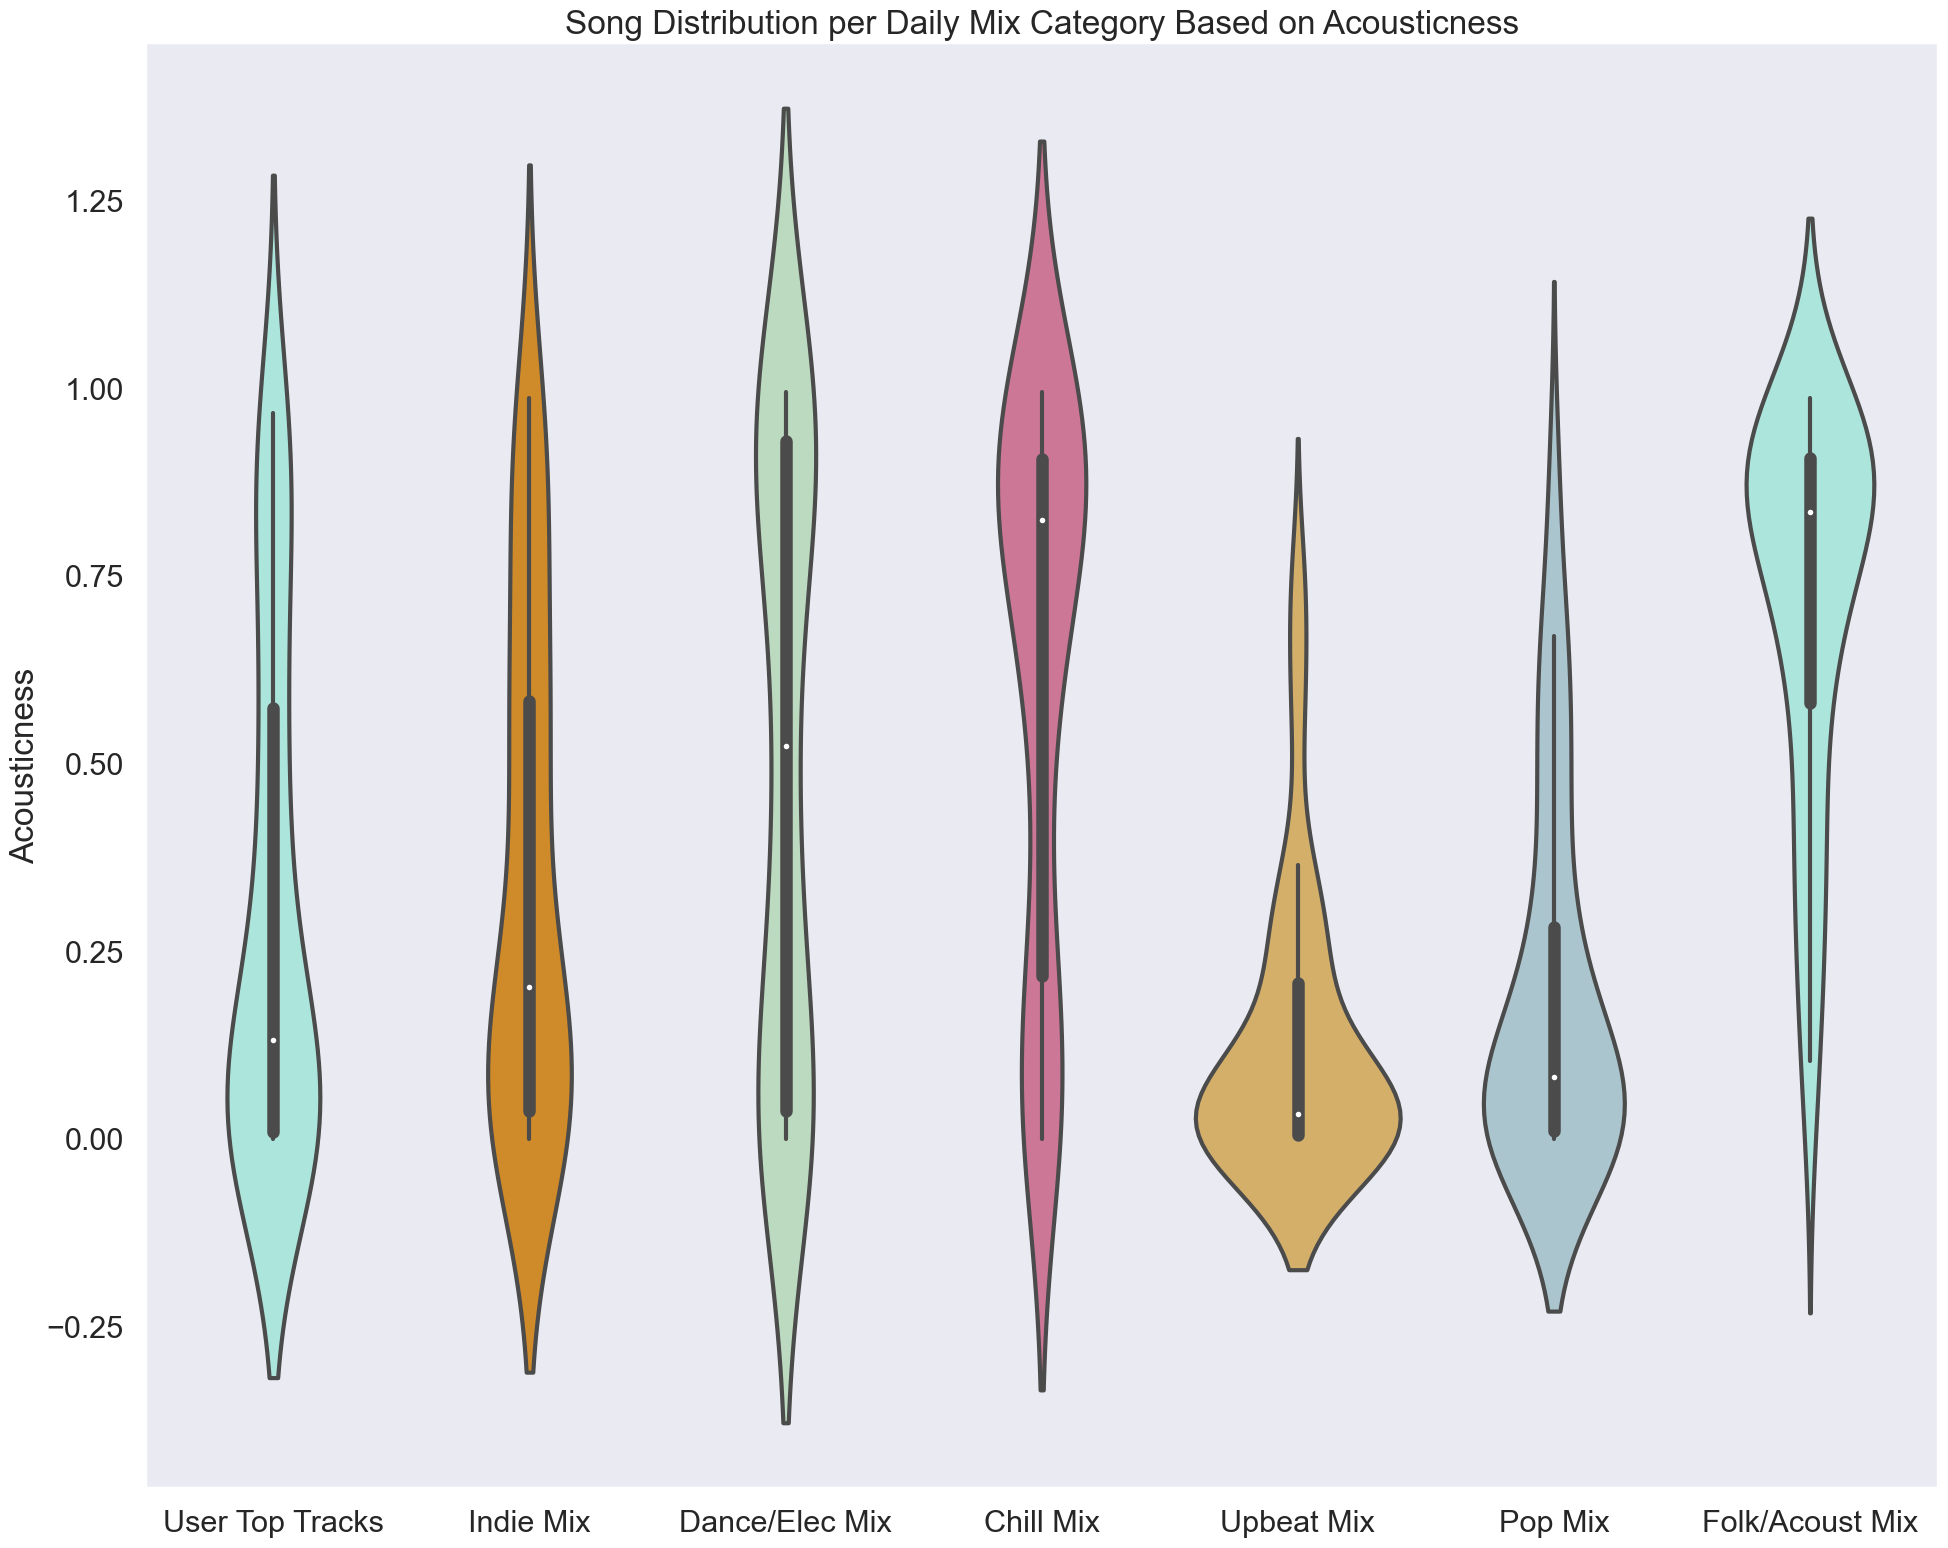

Acousticness
Min: 1.95e-05
Max: 0.996


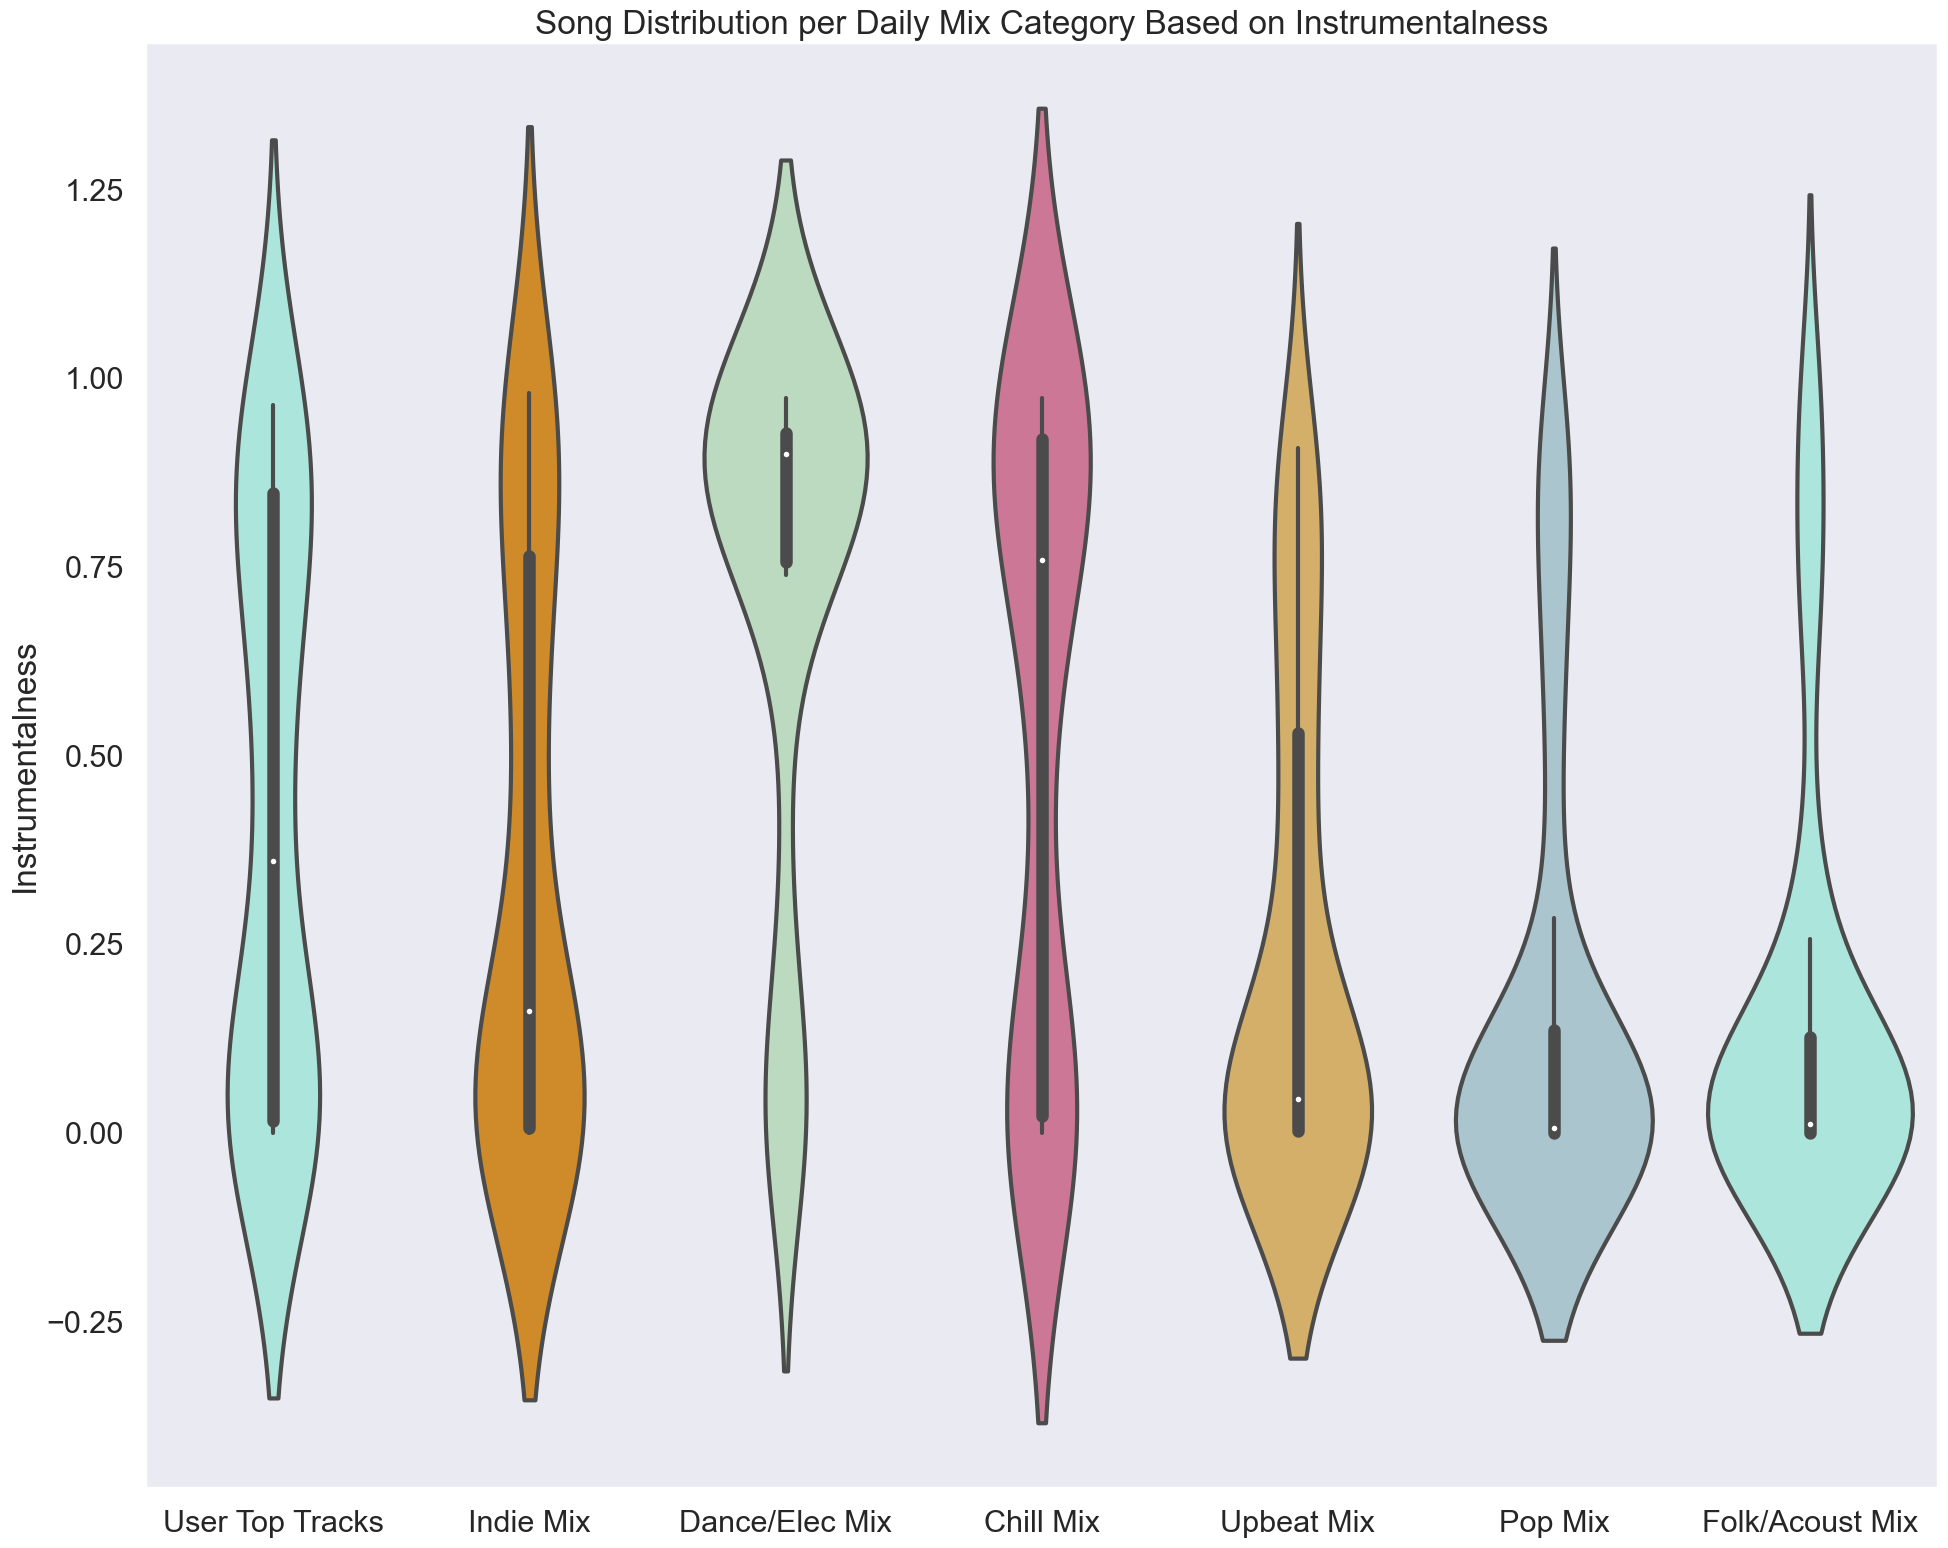

Instrumentalness
Min: 0.0
Max: 0.98


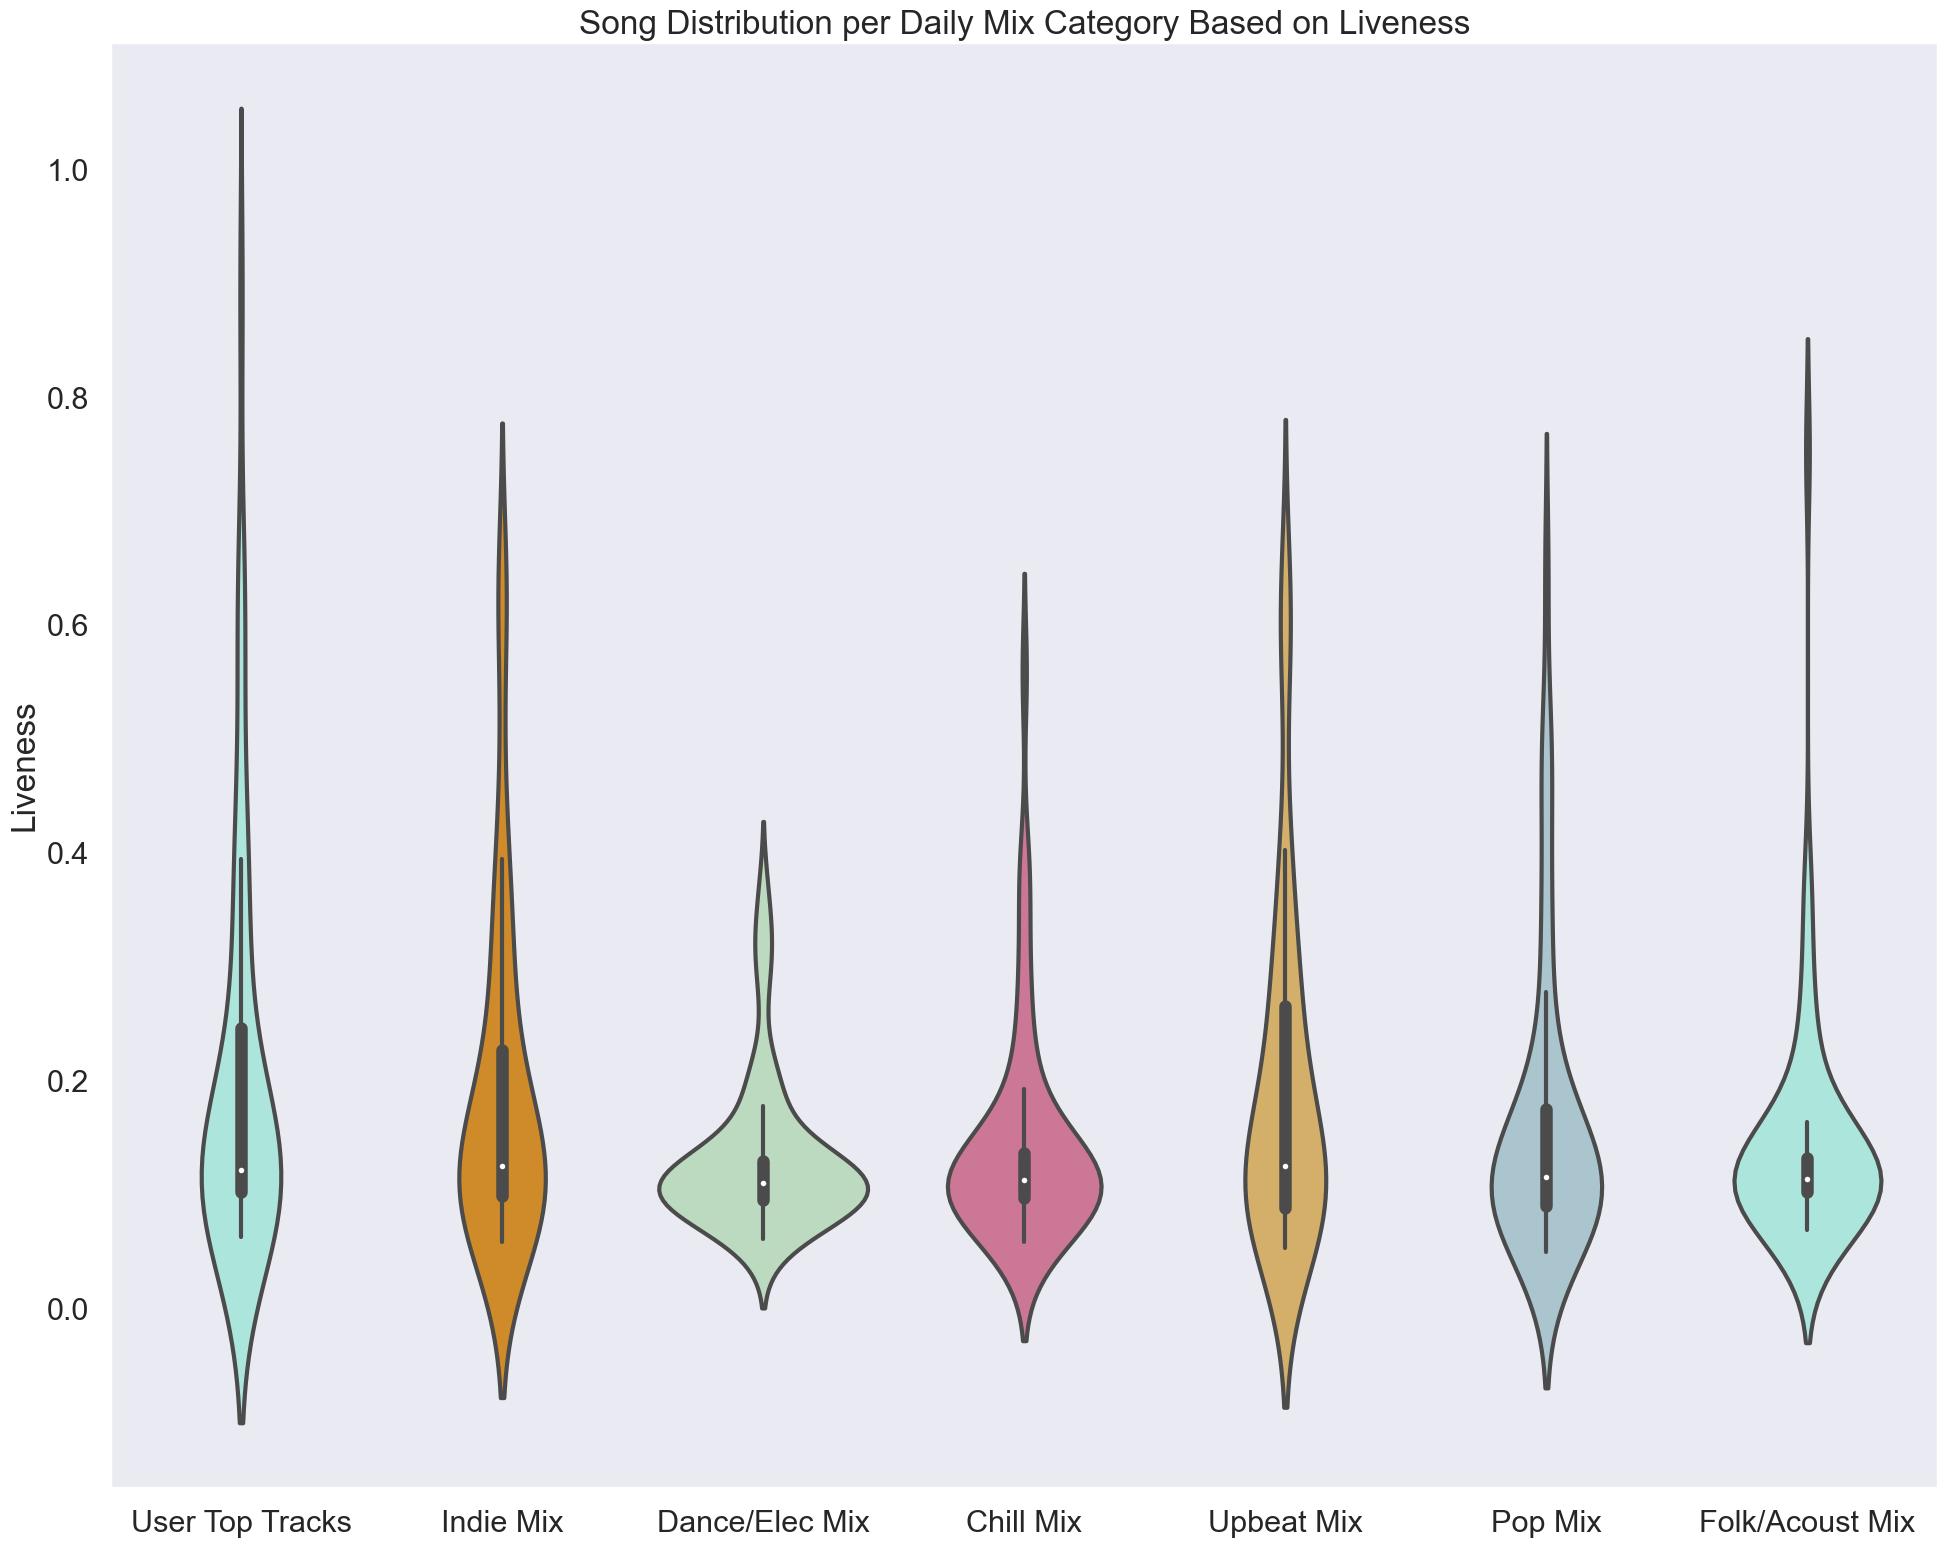

Liveness
Min: 0.0498
Max: 0.891


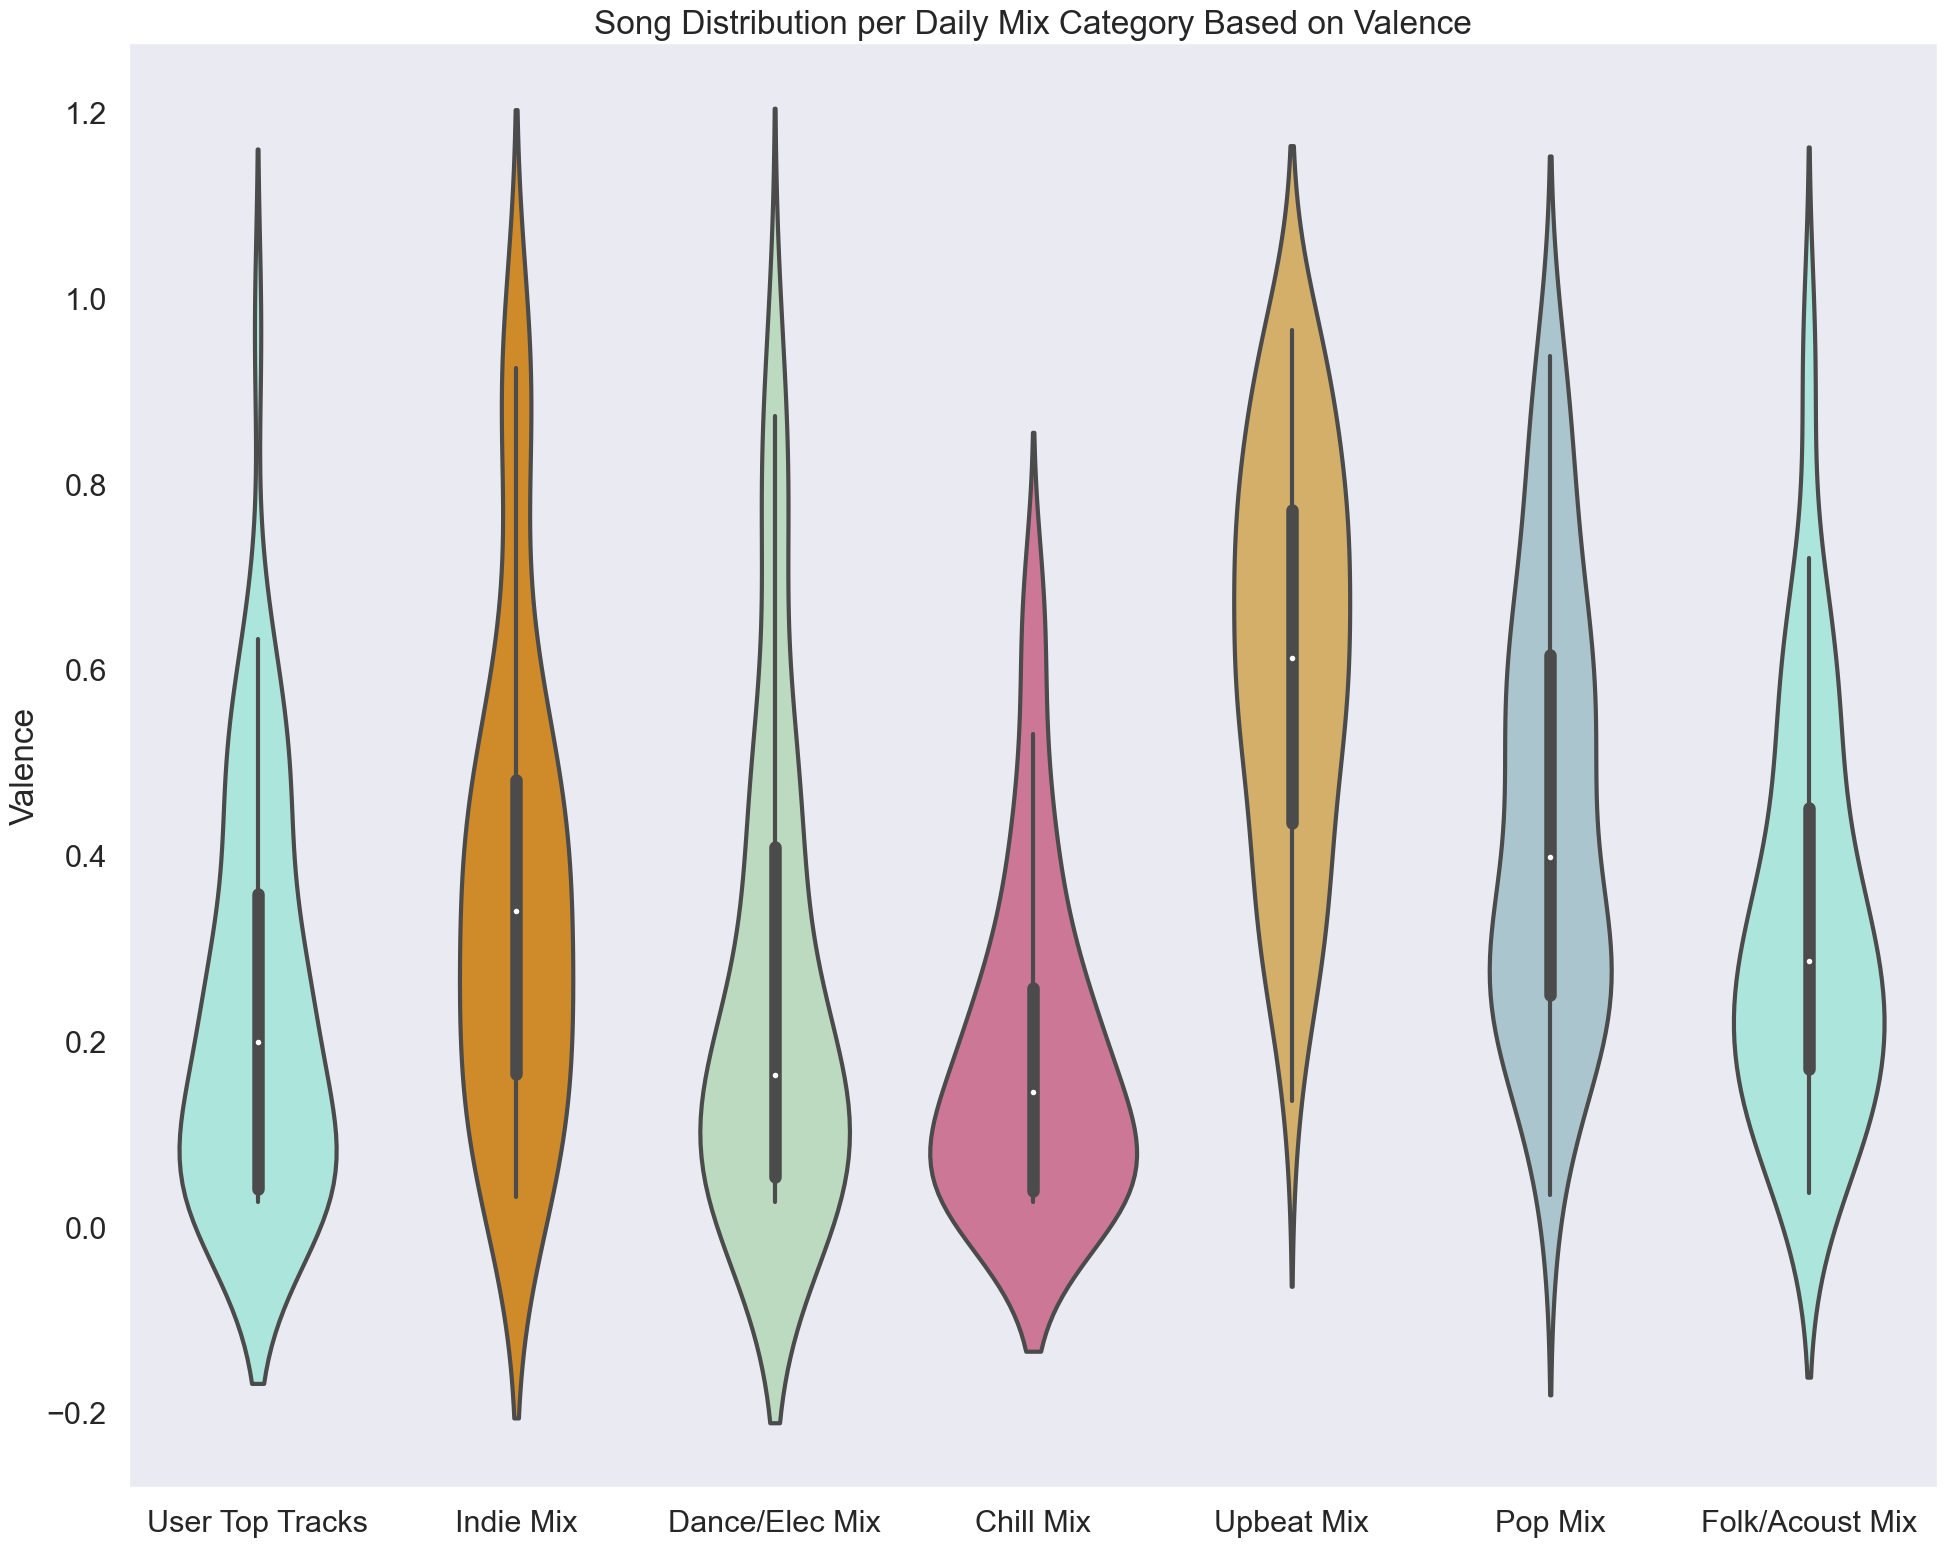

Valence
Min: 0.0273
Max: 0.968


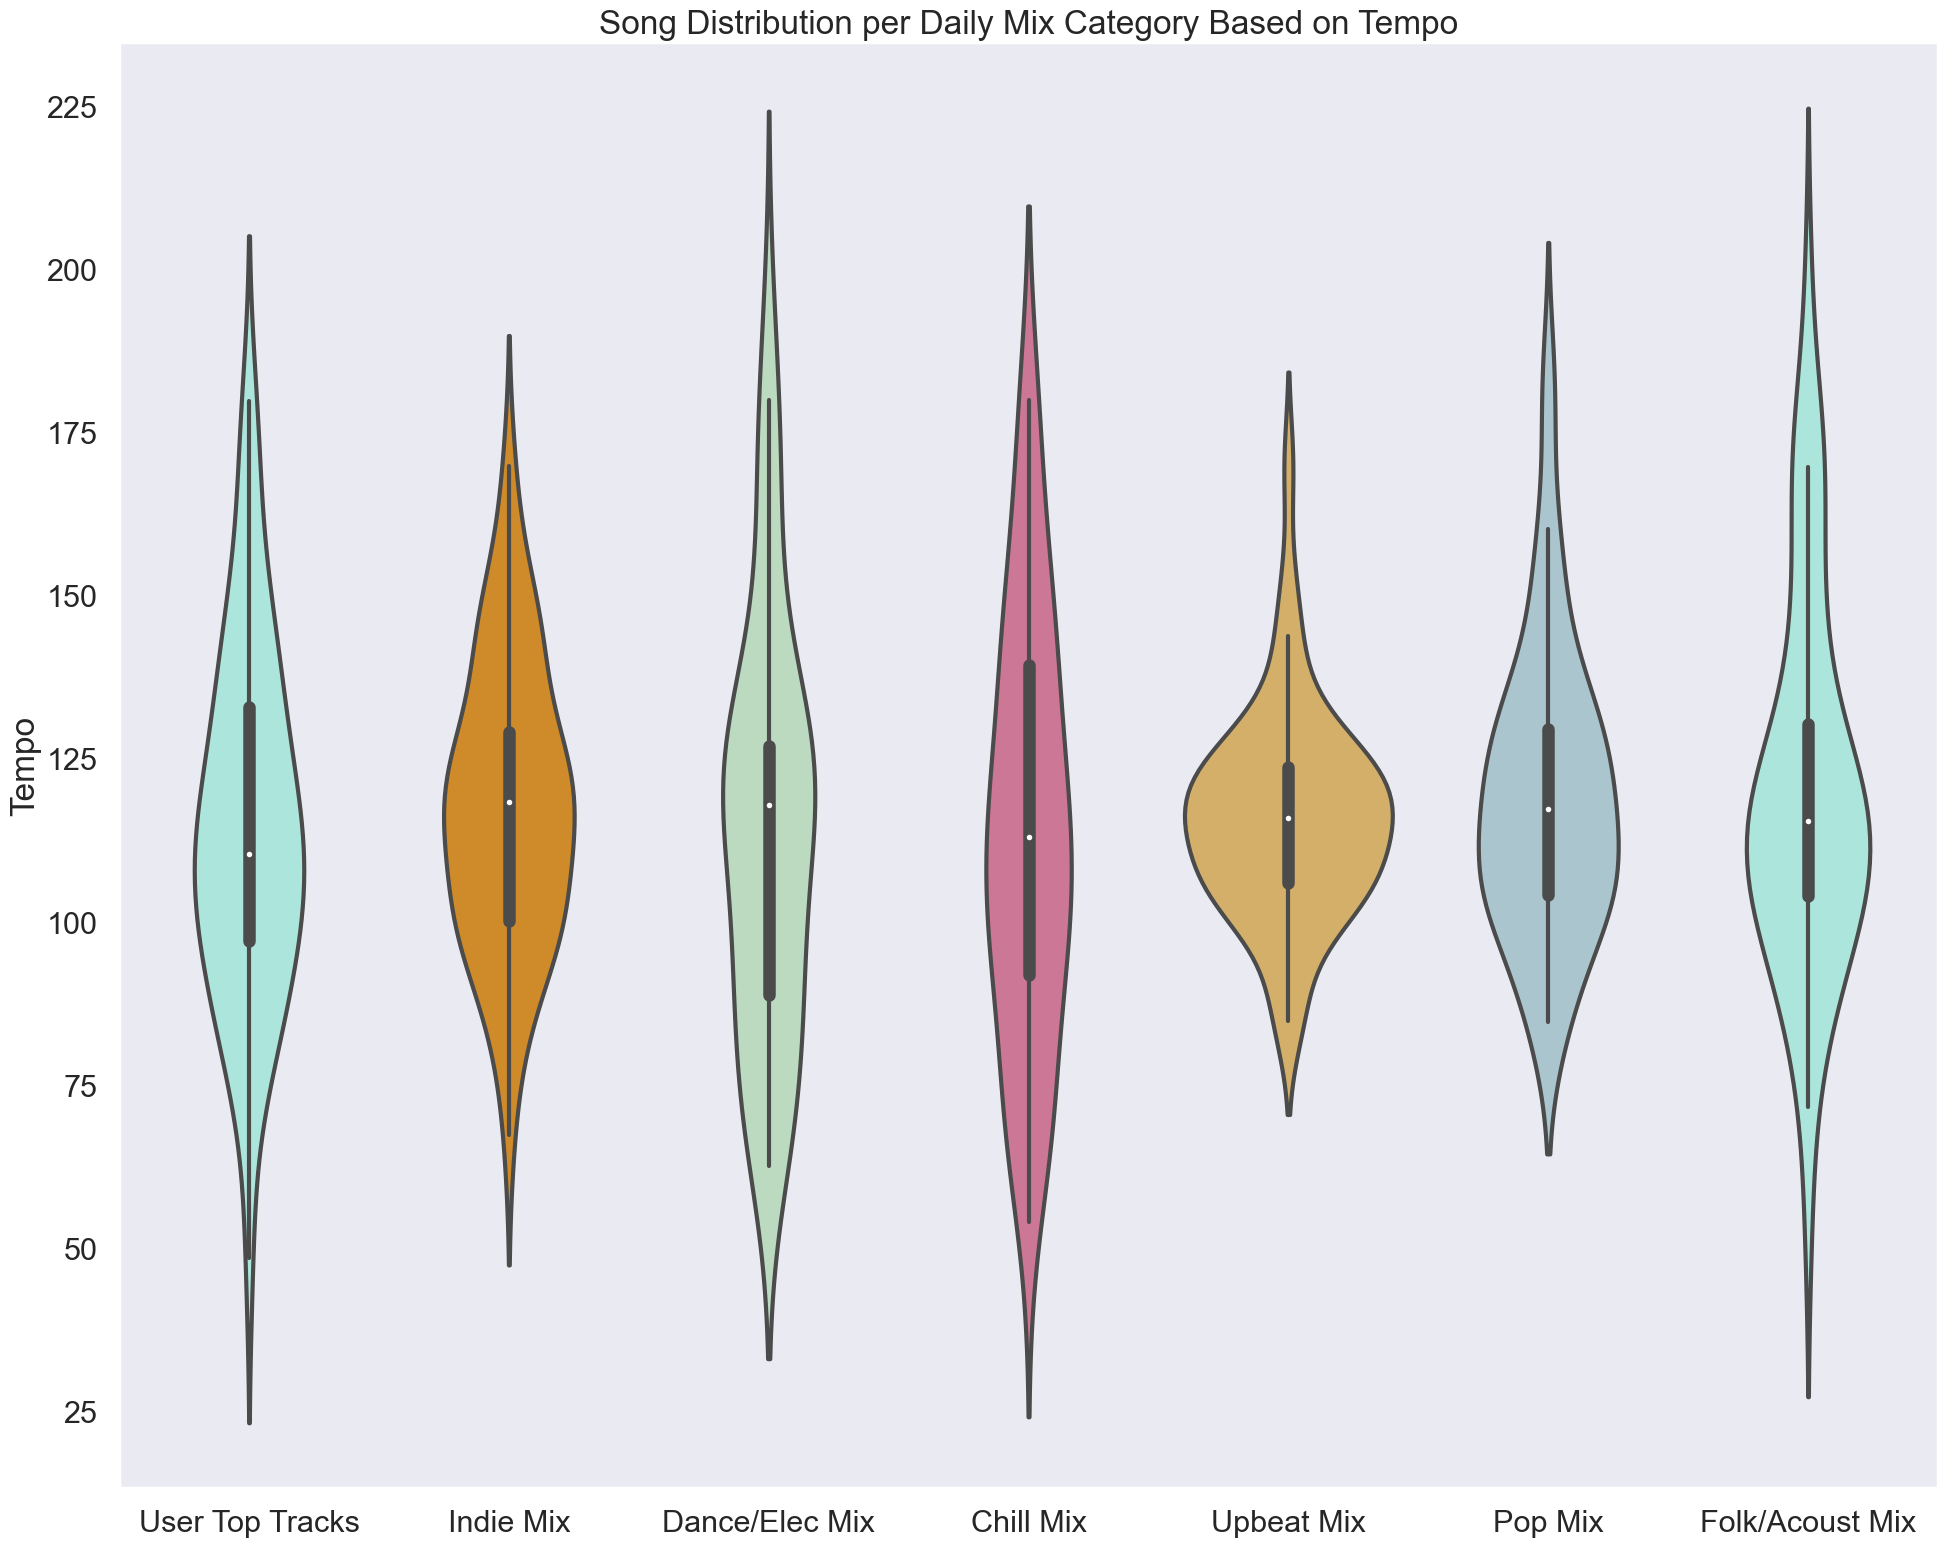

Tempo
Min: 48.637
Max: 198.112


In [5]:
# visualise data in violin plots
# https://medium.com/codex/decoding-spotify-daily-mix-73f4783037b4

cols = spotify_df.loc[:,'danceability':'tempo'].columns.to_list()
colors = ['#a3eee3', '#ea8e0f', '#b7dfbb', '#db6992', '#e4b459', '#a5c8d4']

for col in cols:
    fig, ax = plt.subplots(figsize=(20, 16))
    ax = sns.violinplot(x='source', y=col, data=spotify_df, palette=colors)
    plt.title(f'Song Distribution per Daily Mix Category Based on {col.title()}')
    plt.ylabel(col.title())
    plt.xlabel(None)
    plt.tight_layout()
    plt.show()
    print('{}\nMin: {}\nMax: {}'.format(col.title(), min(spotify_df[col]), max(spotify_df[col])))

In [6]:
# ANOVA test to compare select features, manually selected by me, across all data sets

anova_dance, anova_dance_p = scipy.stats.f_oneway(top_features_df['danceability'], indie_mix['danceability'], dance_electronic_mix['danceability'], chill_mix['danceability'], \
                        upbeat_mix['danceability'], pop_mix['danceability'], folk_acoustic_mix['danceability'])

anova_energy, anova_energy_p = scipy.stats.f_oneway(top_features_df['energy'], indie_mix['energy'], dance_electronic_mix['energy'], chill_mix['energy'], \
                        upbeat_mix['energy'], pop_mix['energy'], folk_acoustic_mix['energy'])

anova_acoustic, anova_acoustic_p = scipy.stats.f_oneway(top_features_df['acousticness'], indie_mix['acousticness'], dance_electronic_mix['acousticness'], chill_mix['acousticness'], \
                        upbeat_mix['acousticness'], pop_mix['acousticness'], folk_acoustic_mix['acousticness'])

d = {"ANOVA Score":[anova_dance,anova_energy,anova_acoustic], "P Value":[anova_dance_p,anova_energy_p,anova_acoustic_p]}
anova_index = ["Danceability", "Energy", "Acousticness"]
anova_df = pd.DataFrame(data=d, index=anova_index)
anova_df

# The z score is very high, and with the low p value this suggests there's some random chance introduced by Spotify when creating the mixes

,ANOVA Score,P Value
Danceability,20.528797,1.514114e-20
Energy,25.898184,2.207050e-25
Acousticness,23.108646,6.608241e-23


In [7]:
# Confirm p value scores and display
anova_alpha = 0.05

for index, p in anova_df["P Value"].items():
    if p <= anova_alpha:
        print(f"The P Value for the ANOVA test on {index} is below 0.05, which is statiscially significant.")
        print(f"The ANOVA is {anova_df.loc[index, 'ANOVA Score']}")
        print()
    else:
        print(f"The P Value for the ANOVA test on {index} is above 0.05, which is not statiscially significant.")
        print(f"The ANOVA is {anova_df.loc[index, 'ANOVA Score']}")
        print()

The P Value for the ANOVA test on Danceability is below 0.05, which is statiscially significant.
The ANOVA is 20.528796926896636

The P Value for the ANOVA test on Energy is below 0.05, which is statiscially significant.
The ANOVA is 25.898184495090177

The P Value for the ANOVA test on Acousticness is below 0.05, which is statiscially significant.
The ANOVA is 23.108645549903482



In [8]:
# T test on select data sets, manually selected by me, for the same select features

t_indie_dance, t_indie_dance_p = scipy.stats.ttest_ind(top_features_df['danceability'], indie_mix['danceability'])
t_indie_energy, t_indie_energy_p = scipy.stats.ttest_ind(top_features_df['energy'], indie_mix['energy'])
t_indie_acoustic, t_indie_acoustic_p = scipy.stats.ttest_ind(top_features_df['acousticness'], indie_mix['acousticness'])

t_upbeat_dance, t_upbeat_dance_p = scipy.stats.ttest_ind(top_features_df['danceability'], upbeat_mix['danceability'])
t_upbeat_energy, t_upbeat_energy_p = scipy.stats.ttest_ind(top_features_df['energy'], upbeat_mix['energy'])
t_upbeat_acoustic, t_upbeat_acoustic_p = scipy.stats.ttest_ind(top_features_df['acousticness'], upbeat_mix['acousticness'])

d = {"T Score":[t_indie_dance, t_indie_energy, t_indie_acoustic, t_upbeat_dance, t_upbeat_energy, t_upbeat_acoustic], \
     "P Value":[t_indie_dance_p, t_indie_energy_p, t_indie_acoustic_p, t_upbeat_dance_p, t_upbeat_energy_p, t_upbeat_acoustic_p]}
t_index = ["Indie Danceability", "Indie Energy", "Indie Acousticness", "Upbeat Danceability", "Upbeat Energy", "Upbeat Acousticness"]

t_df = pd.DataFrame(data=d, index=t_index)
t_df

# The T scores for the Indie category are much lower on average than the Upbeat category
# Yet for a small T score, the P Value can be high, and for a larger T score, the P Value may be quite low
# Once again this is suggesting built in randomness

,T Score,P Value
Indie Danceability,-2.938029,4.118093e-03
Indie Energy,-1.702683,9.179732e-02
Indie Acousticness,-0.640926,5.230670e-01
Upbeat Danceability,-8.011212,2.400994e-12
Upbeat Energy,-6.188643,1.413418e-08
Upbeat Acousticness,3.215280,1.765451e-03


In [9]:
# Confirm p value scores and display

t_alpha = 0.05

for index, p in t_df["P Value"].items():
    if p <= t_alpha:
        print(f"The P Value for the T Test on {index} is below 0.05, which is statiscially significant.")
        print(f"The T Score is {t_df.loc[index, 'T Score']}")
        print()
    elif p > t_alpha:
        print(f"The P Value for the T Test test on {index} is above 0.05, which is not statiscially significant.")
        print(f"The T Score is {t_df.loc[index, 'T Score']}")
        print()

The P Value for the T Test on Indie Danceability is below 0.05, which is statiscially significant.
The T Score is -2.9380290272997005

The P Value for the T Test test on Indie Energy is above 0.05, which is not statiscially significant.
The T Score is -1.7026827261644146

The P Value for the T Test test on Indie Acousticness is above 0.05, which is not statiscially significant.
The T Score is -0.640925591803937

The P Value for the T Test on Upbeat Danceability is below 0.05, which is statiscially significant.
The T Score is -8.011212383145718

The P Value for the T Test on Upbeat Energy is below 0.05, which is statiscially significant.
The T Score is -6.188642531264253

The P Value for the T Test on Upbeat Acousticness is below 0.05, which is statiscially significant.
The T Score is 3.2152802089816896



In [10]:
# Running Pearson Regression, although I'm not convinced this is an appropriate test

pear_indie_dance, pear_indie_dance_p = scipy.stats.pearsonr(top_features_df['danceability'], indie_mix['danceability'])
pear_indie_energy, pear_indie_energy_p = scipy.stats.pearsonr(top_features_df['energy'], indie_mix['energy'])
pear_indie_acoustic, pear_indie_acoustic_p = scipy.stats.pearsonr(top_features_df['acousticness'], indie_mix['acousticness'])

pear_upeat_dance, pear_upbeat_dance_p = scipy.stats.pearsonr(top_features_df['danceability'], upbeat_mix['danceability'])
pear_upbeat_energy, pear_upbeat_energy_p = scipy.stats.pearsonr(top_features_df['energy'], upbeat_mix['energy'])
pear_upbeat_acoustic, pear_upbeat_acoustic_p = scipy.stats.pearsonr(top_features_df['acousticness'], upbeat_mix['acousticness'])

d = {"Pearson R Score":[pear_indie_dance, pear_indie_energy, pear_indie_acoustic, pear_upeat_dance, pear_upbeat_energy, pear_upbeat_acoustic], \
     "P Value":[pear_indie_dance_p, pear_indie_energy_p, pear_indie_acoustic_p, pear_upbeat_dance_p, pear_upbeat_energy_p, pear_upbeat_acoustic_p]}
pear_index = ["Indie Danceability", "Indie Energy", "Indie Acousticness", "Upbeat Danceability", "Upbeat Energy", "Upbeat Acousticness"]

pear_df = pd.DataFrame(data=d, index=pear_index)
pear_df

,Pearson R Score,P Value
Indie Danceability,-0.241907,0.090547
Indie Energy,-0.072845,0.615151
Indie Acousticness,-0.131232,0.363658
Upbeat Danceability,0.021480,0.882294
Upbeat Energy,-0.064756,0.655035
Upbeat Acousticness,-0.153478,0.287271


In [11]:
# Confirm p value scores and display
pear_alpha = 0.05

for index, p in pear_df["P Value"].items():
    if p <= pear_alpha:
        print(f"The P Value for the Pearson Regression on {index} is below 0.05, which is statiscially significant.")
        print(f"The R Value is {pear_df.loc[index, 'Pearson R Score']}")
        print()
    elif p > pear_alpha:
        print(f"The P Value for the Pearson Regression test on {index} is above 0.05, which is not statiscially significant.")
        print(f"The R Value is {pear_df.loc[index, 'Pearson R Score']}")
        print()

# This test doesn't appear to produce useful results, as there's very little correlation and no statistical significance

The P Value for the Pearson Regression test on Indie Danceability is above 0.05, which is not statiscially significant.
The R Value is -0.24190713691656712

The P Value for the Pearson Regression test on Indie Energy is above 0.05, which is not statiscially significant.
The R Value is -0.07284522133889929

The P Value for the Pearson Regression test on Indie Acousticness is above 0.05, which is not statiscially significant.
The R Value is -0.13123210088321127

The P Value for the Pearson Regression test on Upbeat Danceability is above 0.05, which is not statiscially significant.
The R Value is 0.021480015641995642

The P Value for the Pearson Regression test on Upbeat Energy is above 0.05, which is not statiscially significant.
The R Value is -0.0647555381277302

The P Value for the Pearson Regression test on Upbeat Acousticness is above 0.05, which is not statiscially significant.
The R Value is -0.1534784088315257



In [18]:
# Begin track recommendation
# get The Weeknd data

sp = spotipy.Spotify(auth_manager=SpotifyOAuth())

artist_name = 'The Weeknd'
artist_id = ""
results = sp.search(q=f'artist:{artist_name}', type='artist', limit=1)

if results['artists']['items']:
    artist_id = results['artists']['items'][0]['id']
    sp.artist_top_tracks(artist_id)
else:
    print(f"No artist found with the name '{artist_name}'")

top_weeknd = sp.artist_top_tracks(artist_id)

top_weeknd_track_ids = []

for i in top_weeknd['tracks']:
    top_weeknd_track_ids.append(i['id'])

top_weeknd_features = sp.audio_features(top_weeknd_track_ids)
top_weeknd_df = pd.DataFrame(data=top_weeknd_features, columns=top_weeknd_features[0].keys())
top_weeknd_features_df = top_weeknd_df.drop(columns=["type", "id","uri","track_href", "analysis_url", "time_signature"])

# Standardise data with Z scores
features_z_score = scipy.stats.zscore(top_features_df.drop(columns='source').iloc[:10])
top_weeknd_z_scores = scipy.stats.zscore(top_weeknd_features_df)
top_weeknd_z_scores.head()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-1.351575,0.107771,1.6855,0.429969,1.0,-0.745804,-0.593710,-0.333939,-0.195169,-0.885742,-1.046234,0.774647
1,0.223757,-0.446478,1.3484,0.052612,1.0,2.476512,0.057882,-0.333710,-0.364058,0.404262,2.047343,0.406637
2,1.989736,0.487533,-0.6742,0.435671,1.0,1.328512,-0.575631,-0.332607,1.493727,2.066730,-0.684433,0.019130
3,-1.431847,1.021254,-0.6742,0.612946,1.0,-0.376333,-0.993252,-0.330493,-0.683598,-0.286163,1.576269,-0.379781
4,-0.709401,-1.082838,-0.6742,-0.024103,-1.0,-0.353900,-0.168103,-0.333939,-0.384325,0.504191,0.402322,1.177203


In [19]:
top_weeknd_z_scores

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-1.351575,0.107771,1.6855,0.429969,1.0,-0.745804,-0.593710,-0.333939,-0.195169,-0.885742,-1.046234,0.774647
1,0.223757,-0.446478,1.3484,0.052612,1.0,2.476512,0.057882,-0.333710,-0.364058,0.404262,2.047343,0.406637
2,1.989736,0.487533,-0.6742,0.435671,1.0,1.328512,-0.575631,-0.332607,1.493727,2.066730,-0.684433,0.019130
3,-1.431847,1.021254,-0.6742,0.612946,1.0,-0.376333,-0.993252,-0.330493,-0.683598,-0.286163,1.576269,-0.379781
4,-0.709401,-1.082838,-0.6742,-0.024103,-1.0,-0.353900,-0.168103,-0.333939,-0.384325,0.504191,0.402322,1.177203
5,0.584980,-1.647350,0.6742,-2.862057,-1.0,-0.146733,1.654848,2.999998,-0.586993,0.131726,-0.969125,-2.665958
6,0.233791,2.006585,-1.0113,0.844648,1.0,-0.757680,-0.844554,-0.333491,2.378709,1.121939,-0.086969,0.023267
7,0.584980,-0.107771,-0.6742,0.576144,-1.0,-0.526760,2.136951,-0.333939,-0.734265,-1.022010,-0.718323,0.175648
8,-0.719435,-0.682547,-1.0113,0.027732,-1.0,-0.485854,-0.498796,-0.333939,-0.377570,-1.180989,-0.245522,0.711760
9,0.595014,0.343839,1.0113,-0.093562,-1.0,-0.411960,-0.175636,-0.333939,-0.546459,-0.853946,-0.275329,-0.242553


In [20]:
features_z_score

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.080301,0.863263,0.968864,0.772168,0.333333,-0.792124,-0.878050,-0.487555,-0.895817,0.524854,2.257836,0.840463
1,-0.657468,-1.166902,-1.245682,-0.605964,0.333333,0.387841,0.983393,-0.271463,-0.629015,-1.014409,-1.188378,-1.562645
2,0.105396,-0.390975,-0.138409,-0.656384,0.333333,-1.130639,1.905922,-0.521373,2.566016,-0.619467,0.080736,-0.613140
3,0.235886,-0.925975,-0.968864,-1.663222,0.333333,1.848290,0.032566,1.823537,-0.112979,0.271686,-0.558235,1.167333
4,-0.853203,-1.586752,1.522500,-1.429224,0.333333,-0.066736,-0.773940,2.127326,-0.365507,-0.956542,0.447189,-1.657696
5,0.125471,0.859720,0.138409,0.636164,0.333333,-0.966217,-0.873137,-0.618033,-0.497261,-0.957989,-0.019170,1.064927
6,-1.254711,1.238825,1.522500,1.087871,-3.000000,1.035855,-0.878518,-0.199815,1.116724,-0.623807,-0.426974,0.813972
7,0.747808,1.348660,0.138409,1.203965,0.333333,1.180932,-0.845478,-0.618123,-0.637799,0.481454,0.043474,0.000757
8,2.399007,-0.468922,-0.968864,-0.194593,0.333333,-0.724421,-0.007052,-0.618242,-0.376487,2.340432,0.818576,-0.559491
9,-0.928486,0.229058,-0.968864,0.849219,0.333333,-0.772780,1.334294,-0.616259,-0.167876,0.553787,-1.455054,0.505521


In [21]:
# Using cosine similarity to find most similar song
# Inspired by source, but they used more complex methods to prepare the data before applying the cosine similarity
# https://towardsdatascience.com/part-iii-building-a-song-recommendation-system-with-spotify-cf76b52705e7
# Also used ChatGPT for help

similarity_matrix = cosine_similarity(top_weeknd_z_scores.values, features_z_score.values)

similarity_df = pd.DataFrame(similarity_matrix, index=top_weeknd_z_scores.index, columns=features_z_score.index)

# Exclude diagonal elements (similarity of track with itself)
similarity_matrix[np.diag_indices_from(similarity_matrix)] = -np.inf

# Find the best similarity for each track in top_weeknd_z_scores
best_similarity = similarity_matrix.max(axis=1)

# Add the best similarity as a new column in top_weeknd_z_scores
top_weeknd_df['best_similarity'] = best_similarity

# Display the updated DataFrame
top_weeknd_df_sorted = top_weeknd_df.sort_values(by='best_similarity', ascending=False)


In [22]:
top_weeknd_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,best_similarity
0,0.522,0.641,8,-6.287,1,0.0318,0.05450,0.000000,0.1620,0.202,87.510,audio_features,7CyPwkp0oE8Ro9Dd5CUDjW,spotify:track:7CyPwkp0oE8Ro9Dd5CUDjW,https://api.spotify.com/v1/tracks/7CyPwkp0oE8R...,https://api.spotify.com/v1/audio-analysis/7CyP...,244685,4,0.547879
1,0.679,0.587,7,-7.015,1,0.2760,0.14100,0.000006,0.1370,0.486,186.003,audio_features,7MXVkk9YMctZqd1Srtv4MB,spotify:track:7MXVkk9YMctZqd1Srtv4MB,https://api.spotify.com/v1/tracks/7MXVkk9YMctZ...,https://api.spotify.com/v1/audio-analysis/7MXV...,230453,4,0.402101
2,0.855,0.678,1,-6.276,1,0.1890,0.05690,0.000037,0.4120,0.852,99.029,audio_features,6WzRpISELf3YglGAh7TXcG,spotify:track:6WzRpISELf3YglGAh7TXcG,https://api.spotify.com/v1/tracks/6WzRpISELf3Y...,https://api.spotify.com/v1/audio-analysis/6WzR...,215467,4,0.567624
3,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4,0.589635
4,0.586,0.525,1,-7.163,0,0.0615,0.11100,0.000000,0.1340,0.508,133.629,audio_features,2LBqCSwhJGcFQeTHMVGwy3,spotify:track:2LBqCSwhJGcFQeTHMVGwy3,https://api.spotify.com/v1/tracks/2LBqCSwhJGcF...,https://api.spotify.com/v1/audio-analysis/2LBq...,260253,4,0.199747


In [23]:
# Sort and check top track
top_weeknd_df_sorted.reset_index(drop=True, inplace=True)
top_weeknd_df_sorted.loc[0:0, ["id", "best_similarity"]]

,id,best_similarity
0,5gDWsRxpJ2lZAffh5p7K0w,0.683569


In [28]:
# Retrieve name from Spotify API
weeknd_track_id = top_weeknd_df_sorted.loc[0:0, "id"]
weeknd_track_info = sp.track(weeknd_track_id[0])
weeknd_track_name = weeknd_track_info['album']['name']
weeknd_track_name


'Starboy'